In [1]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [2]:
import os
import sys
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
import h5py

tf.keras.backend.set_floatx('float32')

In [3]:
colab_flag = False
FTYPE = np.float32
ITYPE = np.int32

array = np.array
float32 = np.float32
int32 = np.int32
float64 = np.float64
int64 = np.int64

strategy = None
# strategy = tf.distribute.MirroredStrategy()

In [4]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [5]:
if colab_flag == True:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Github/MLROM/KS/')

In [6]:
print(os.getcwd())

/home/rkaushik/Documents/Thesis/MLROM/KS


In [7]:
from tools.misc_tools import create_data_for_RNN, mytimecallback, SaveLosses, plot_losses, plot_reconstructed_data_KS, plot_latent_states_KS , readAndReturnLossHistories, sigmoidWarmupAndDecayLRSchedule
from tools.ae_v5 import Autoencoder
from tools.ESN_v4 import ESN

In [8]:
behaviour = 'initialiseAndTrainFromScratch'
# behaviour = 'loadCheckpointAndContinueTraining'
# behaviour = 'loadFinalNetAndPlot'

In [9]:
# setting seed for PRNGs
if behaviour == 'initialiseAndTrainFromScratch':
    prng_seed = 42
    np.random.seed(prng_seed)
    tf.random.set_seed(prng_seed)

In [10]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

if colab_flag == False:
    if strategy is None:
        if gpus:
            gpu_to_use = 0
            tf.config.set_visible_devices(gpus[gpu_to_use], 'GPU')
    logical_devices = tf.config.list_logical_devices('GPU')
    print(logical_devices)

2022-12-23 03:12:43.180916: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


2022-12-23 03:12:43.181149: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-23 03:12:43.223138: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-23 03:12:43.223515: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-23 03:12:43.223823: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-23 03:12:43.224129: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [11]:
# print(tf.test.gpu_device_name())
print(tf.config.list_physical_devices())
print(tf.config.list_logical_devices())
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]
2.8.1


# KS System

In [12]:
# setting up params (and saving, if applicable)
# from numpy import *

if behaviour == 'initialiseAndTrainFromScratch':
    # making RNN save directory
    dir_name_rnn = os.getcwd() + dir_sep + 'saved_ESN'
    if not os.path.isdir(dir_name_rnn):
        os.makedirs(dir_name_rnn)

    counter = 0
    while True:
        dir_check = 'ESN_' + str(counter).zfill(3)
        if os.path.isdir(dir_name_rnn + dir_sep + dir_check):
            counter += 1
        else:
            break

    dir_name_rnn = dir_name_rnn + dir_sep + dir_check
    os.makedirs(dir_name_rnn)
    os.makedirs(dir_name_rnn+dir_sep+'plots')
    
    # whether to use AE data or just work on raw data
    use_ae_data = True # if false, specifying ae_idx will only show which dataset to use
    
    # autoencoder directory
    ae_idx = '046'
    dir_name_ae = os.getcwd()+'{ds}saved_ae{ds}ae_'.format(ds=dir_sep)+ae_idx
else:
    # RNN directory
    dir_name_rnn = os.getcwd()+'/saved_ESN/ESN_026'

    # reading AE directory
    with open(dir_name_rnn + '/sim_data_AE_params.txt') as f:
        lines = f.readlines()

    params_dict = eval(''.join(lines))

    use_ae_data = params_dict['use_ae_data']
    
    dir_name_ae = params_dict['dir_name_ae']
    ae_idx = dir_name_ae[-3:]
    dir_name_ae = os.getcwd()+'/saved_ae/ae_'+ae_idx

    # reading RNN paramaters
    with open(dir_name_rnn + '/RNN_specific_data.txt') as f:
        lines = f.readlines()

    params_rnn_dict = eval(''.join(lines))

    dt_rnn = params_rnn_dict['dt_rnn']
    T_sample_input = params_rnn_dict['T_sample_input']
    T_sample_output = params_rnn_dict['T_sample_output']
    T_offset = params_rnn_dict['T_offset']
    return_params_arr = params_rnn_dict['return_params_arr']
    params = params_rnn_dict['params']
    try:
        normalize_dataset = params_rnn_dict['normalize_dataset']
    except:
        print("'normalize_dataset' not present in RNN_specific_data, set to False.")
        normalize_dataset = False
    try:
        stddev_multiplier = params_rnn_dict['stddev_multiplier']
    except:
        print("'stddev_multiplier' not present in RNN_specific_data, set to None.")
        stddev_multiplier = None
    try:
        skip_intermediate = params_rnn_dict['skip_intermediate']
    except:
        print("'skip_intermediate' not present in RNN_specific_data, set to 1.")
        skip_intermediate = 1
    try:
        normalization_type = params_rnn_dict['normalization_type']
    except:
        print("'normalization_type' not present in RNN_specific_data, set to 'stddev'.")
        normalization_type = 'stddev'
    

    normalization_arr = None
    try:
        with open(dir_name_rnn + '/final_net/rnn_normalization.txt') as f:
            lines = f.readlines()
        rnn_norm_arr_dict = eval(lines)
        normalization_arr = rnn_norm_arr_dict['normalization_arr']
    except:
        pass
    if os.path.exists(dir_name_rnn+dir_sep+'normalization_data.npz'):
        with np.load(dir_name_rnn+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
            normalization_arr = fl['normalization_arr'][0]

# reading simulation parameters
with open(dir_name_ae + dir_sep + 'ae_data.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
data_dir_idx = params_dict['data_dir_idx']
normalizeforae_flag = params_dict['normalizeforae_flag']
normalization_constant_arr_aedata = params_dict['normalization_constant_arr_aedata']
try:
    ae_data_with_params = params_dict['ae_data_with_params']
except:
    print("'ae_data_with_params' not present in ae_data, set to 'True'.")
    ae_data_with_params = True

if os.path.exists(dir_name_ae+dir_sep+'normalization_data.npz'):
    with np.load(dir_name_ae+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
        normalization_constant_arr_aedata = fl['normalization_constant_arr_aedata'][0]

print('dir_name_rnn:', dir_name_rnn)
print('use_ae_data : ' + str(use_ae_data) + ', dir_name_ae:', dir_name_ae)
print('data_dir_idx:', data_dir_idx)

# loading data
dir_name_data = os.getcwd() + dir_sep + 'saved_data' + dir_sep + 'data_' + data_dir_idx
    
with open(dir_name_data + dir_sep + 'sim_data_params.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
params_mat = params_dict['params_mat']
# init_state = params_dict['init_state']
t0 = params_dict['t0']
T = params_dict['T']
delta_t = params_dict['delta_t']
numpoints_xgrid = params_dict['numpoints_xgrid']
length = params_dict['length']
return_params_arr = params_dict['return_params_arr']
normalize_flag_ogdata = params_dict['normalize_flag']
print('normalize_flag_ogdata:', normalize_flag_ogdata)
alldata_withparams_flag = params_dict['alldata_withparams_flag']

xgrid = length*np.linspace(0, 1, numpoints_xgrid)

with np.load(dir_name_data+dir_sep+'data.npz', allow_pickle=True) as fl:
    all_data = fl['all_data']
    boundary_idx_arr = fl['boundary_idx_arr']
    normalization_constant_arr_ogdata = fl['normalization_constant_arr'][0]
    initial_t0 = fl['initial_t0']
    init_state_mat = fl['init_state_mat']

    lyapunov_spectrum_mat = fl['lyapunov_spectrum_mat']

dir_name_rnn: /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029
use_ae_data : True, dir_name_ae: /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_046
data_dir_idx: 005
normalize_flag_ogdata: False


In [13]:
lyapunov_time_arr = np.empty(shape=lyapunov_spectrum_mat.shape[0], dtype=FTYPE)
for i in range(lyapunov_spectrum_mat.shape[0]):
    lyapunov_time_arr[i] = 1/lyapunov_spectrum_mat[i, 0]
    print('Case : {}, lyapunov exponent : {}, lyapunov time : {}s'.format(i+1, lyapunov_spectrum_mat[i, 0], lyapunov_time_arr[i]))

Case : 1, lyapunov exponent : 0.06465670311438651, lyapunov time : 15.466300964355469s


In [14]:
def plot(
        boundary_idx_arr,
        delta_t,
        all_data,
        xgrid,
        xticks_snapto=20,
        num_yticks=11,
    ):

    n = len(boundary_idx_arr)
    # '''
    num_cols = 1
    num_rows = 1
    factor = 1
    # fig = plt.figure(figsize=(7.5*num_cols, 7.5*num_rows))

    num_modes = xgrid.shape[0]

    prev_idx = 0
    for i in range(len(boundary_idx_arr)):
        next_idx = boundary_idx_arr[i]
        fig, ax = plt.subplots(figsize=(factor*7.5*num_cols, factor*5.0*num_rows))
        N = next_idx - prev_idx
        input_time = np.arange(0, N)*delta_t

        im = ax.imshow(all_data[prev_idx:next_idx, 0:num_modes].transpose(), aspect='auto', origin='lower')
        num_xticks = 1 + int((N*delta_t + 0.5*xticks_snapto) // xticks_snapto)
        # xticks = np.linspace(0, N, num_xticks, dtype=np.int32)
        xticks = np.arange(0, N, int((xticks_snapto+0.5*delta_t)//delta_t))
        ax.set_xticks(ticks=xticks)
        ax.set_xticklabels(np.round(xticks*delta_t, 1))
        ax.tick_params(axis='x', rotation=270+45)

        yticks = np.linspace(0, 1, num_yticks)*(len(xgrid)-1)
        yticklabels = np.round(np.linspace(0, 1, yticks.shape[0])*xgrid[-1], 2)
        ax.set_yticks(ticks=yticks)
        ax.set_yticklabels(yticklabels)

        ax.set_xlabel('Time')
        ax.set_ylabel(r'$x$')
        # ax.title.set_text(r'Latent States')

        plt.colorbar(im)
        plt.show()
        print('')

        prev_idx = next_idx

    # '''

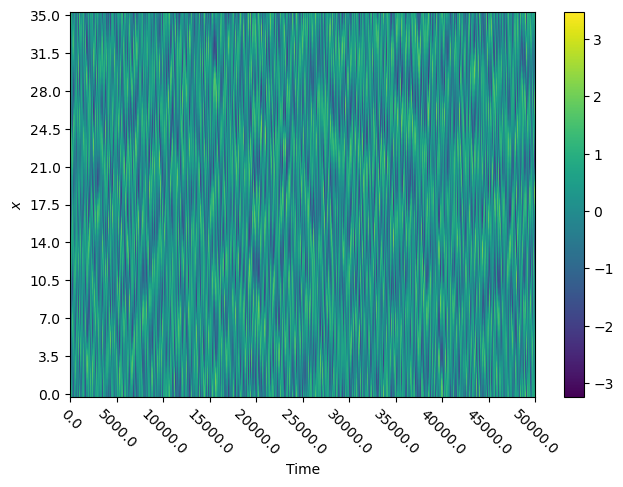

In [15]:
plot(
    boundary_idx_arr,
    delta_t,
    all_data,
    xgrid,
    xticks_snapto=int(40*np.round((T//10)/40))
)

In [16]:
# delaing with normalizing the data before feeding into autoencoder
if use_ae_data == True:
    if normalizeforae_flag == True:
        for i in range(numpoints_xgrid):
            all_data[:, i] -= normalization_constant_arr_aedata[0, i]
            all_data[:, i] /= normalization_constant_arr_aedata[1, i]

    if ae_data_with_params == False:
        all_data = all_data[:, 0:numpoints_xgrid]
else:
    # using raw data, neglecting the params attached (if any)
    all_data = all_data[:, 0:numpoints_xgrid]

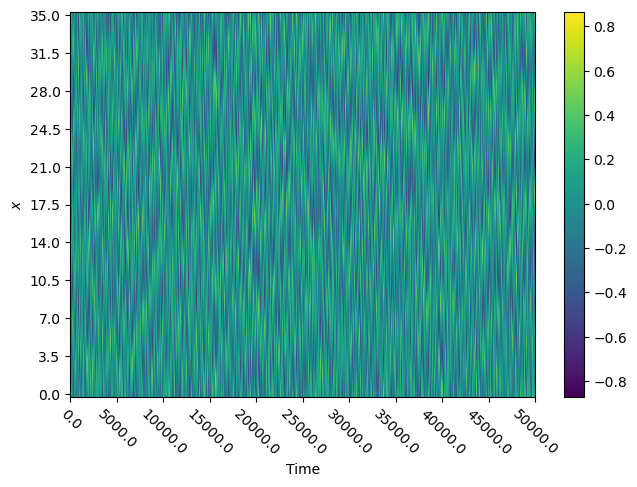

In [17]:
plot(
    boundary_idx_arr,
    delta_t,
    all_data,
    xgrid,
    xticks_snapto=int(40*np.round((T//10)/40))
)

# Autoencoder

In [18]:
if use_ae_data == True:
    load_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_class_dict.txt'
    wt_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_ae_weights.h5'

In [19]:
if use_ae_data == True:
    ae_net = Autoencoder(all_data.shape[1], load_file=load_file)
    ae_net.load_weights_from_file(wt_file)

In [20]:
# create data
if use_ae_data == True:
    latent_states_all = ae_net.encoder_net.predict(all_data)
    del(all_data)
else:
    latent_states_all = all_data
num_latent_states = latent_states_all.shape[1]
time_stddev_AEproducedlatentstates = np.std(latent_states_all, axis=0)

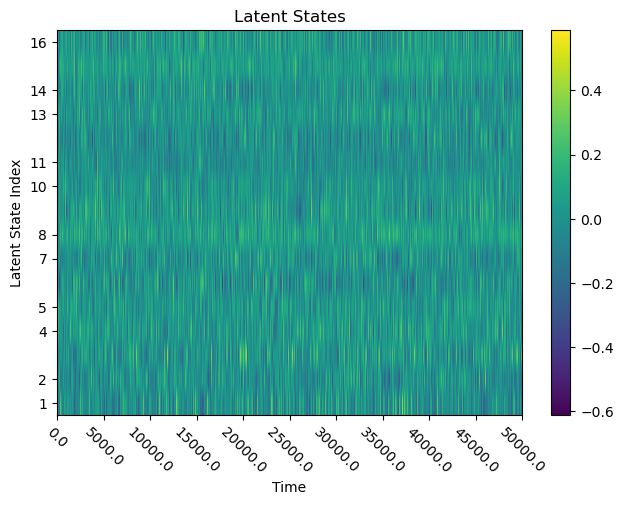

In [21]:
plot_latent_states_KS(
    boundary_idx_arr,
    latent_states_all,
    delta_t,
    dir_name_ae,
    xticks_snapto=int(40*np.round((T//10)/40)),
    num_yticks=11,
    save_figs=False)

In [22]:
# for i in range(ae_net.layers):
#     tf.keras.utils.plot_model(
#         ae_net.layers[i],
#         to_file=dir_name_ae+'/plots/netlayer_{}.png'.format(i),
#         show_shapes=True,
#         dpi=300
# )

# ESN

In [23]:
if behaviour == 'initialiseAndTrainFromScratch':
    # RNN data parameters
    dt_rnn = 0.2
    num_input_tsteps = 375
    T_sample_input = num_input_tsteps*dt_rnn
    T_sample_output = T_sample_input
    T_offset = dt_rnn
    normalize_dataset = True # whether the data for the RNN should be normalized by the dataset's mean and std
    normalization_arr = None
    stddev_multiplier = 3
    skip_intermediate = 'full sample'
    noise_type = 'normal' # can be 'uniform' or 'normal'
    normalization_type = 'stddev' # can be 'minmax' or 'stddev', if it is
                                  # 'minmax' then stddev_multiplier has no effect
    ESN_layers_units = [2000]
    stateful = True
    omega_in = [0.5]
    degree_of_connectivity = [20]
    rho_res = [0.8]
    usebias_Win = [False]
    alpha = [1.0]
    ESN_cell_activations = ['tanh']
    usebias_Wout = True
    
    activation_post_Wout = 'tanh'
    use_weights_post_dense = True
    
    # computing sparsity
    sparsity = [1-degree_of_connectivity[i]/(ESN_layers_units[i]-1) for i in range(len(ESN_layers_units))]
        
    if return_params_arr != False:
        params = params_arr
    else:
        params = None
        

    # saving simulation data
    sim_data = {
        'params_mat':params_mat,
        'init_state_mat':init_state_mat,
        't0':t0,
        'T':T,
        'delta_t':delta_t,
        'return_params_arr':return_params_arr, # pointless, saved_data parameter
        'dir_name_ae':dir_name_ae,
        'normalize_dataset':normalize_dataset, # pointless, RNN parameter
        'stddev_multiplier':stddev_multiplier, # pointless, RNN parameter
        'use_ae_data':use_ae_data,
    }


    with open(dir_name_rnn+dir_sep+'sim_data_AE_params.txt', 'w') as f:
        f.write(str(sim_data))
        
    # saving RNN specific data
    RNN_specific_data = {
        'dt_rnn':dt_rnn,
        'T_sample_input':T_sample_input,
        'T_sample_output':T_sample_output,
        'T_offset':T_offset,
        'boundary_idx_arr':boundary_idx_arr,
        'delta_t':delta_t,
        'params':params,
        'return_params_arr':return_params_arr,
        'normalize_dataset':normalize_dataset,
        'num_input_tsteps':num_input_tsteps,
        'stddev_multiplier':stddev_multiplier,
        'skip_intermediate':skip_intermediate,
        'module':ESN.__module__,
        'noise_type':noise_type,
        'normalization_type':normalization_type,
    }

    with open(dir_name_rnn+dir_sep+'RNN_specific_data.txt', 'w') as f:
        f.write(str(RNN_specific_data))

In [24]:
rnn_res_dict = create_data_for_RNN(
    latent_states_all,
    dt_rnn,
    T_sample_input,
    T_sample_output,
    T_offset,
    None,
    boundary_idx_arr,
    delta_t,
    params=params,
    return_numsamples=True,
    normalize_dataset=normalize_dataset,
    stddev_multiplier=stddev_multiplier,
    skip_intermediate=skip_intermediate,
    return_OrgDataIdxArr=False,
    normalization_arr_external=normalization_arr,
    normalization_type=normalization_type,
    FTYPE=FTYPE,
    ITYPE=ITYPE)
    
data_rnn_input = rnn_res_dict['data_rnn_input']
data_rnn_output = rnn_res_dict['data_rnn_output']
org_data_idx_arr_input = rnn_res_dict['org_data_idx_arr_input']
org_data_idx_arr_output = rnn_res_dict['org_data_idx_arr_output']
num_samples = rnn_res_dict['num_samples']
normalization_arr = rnn_res_dict['normalization_arr']
rnn_data_boundary_idx_arr = rnn_res_dict['rnn_data_boundary_idx_arr']

In [25]:
temp = np.divide(latent_states_all-normalization_arr[0], normalization_arr[1])
time_stddev = np.std(temp, axis=0)
timeMeanofSpaceRMS = np.mean(np.mean(temp**2, axis=1)**0.5)
del(org_data_idx_arr_input)
del(org_data_idx_arr_output)
del(latent_states_all)
del(temp)

In [26]:
# setting up training params
if behaviour == 'initialiseAndTrainFromScratch':
    learning_rate_list = [1e-3, 1e-4, 1e-5]
    epochs = 1000
    patience = 25 # parameter for early stopping
    min_delta = 1e-6  # parameter for early stopping
    lambda_reg = 1e-6  # weight for regularizer
    train_split = 0.8
    val_split = 0.1
    test_split = 1 - train_split - val_split
    batch_size = 32
    fRMS = 0.5/100
    # zoneout_rate = 0.1
    # rnncell_dropout_rate = 0.01
    # denselayer_dropout_rate = 0.01
    

    stddev = fRMS*timeMeanofSpaceRMS
    
    # saving training params
    training_specific_params = {
        'learning_rate_list':learning_rate_list,
        'epochs':epochs,
        'patience':patience,
        'min_delta':min_delta,
        'prng_seed':prng_seed,
        'train_split':train_split,
        'val_split':val_split,
        'batch_size':batch_size,
        'fRMS':fRMS,
        'timeMeanofSpaceRMS':timeMeanofSpaceRMS,
        'stddev':stddev,
        # 'zoneout_rate':zoneout_rate,
        # 'rnncell_dropout_rate':rnncell_dropout_rate,
        # 'denselayer_dropout_rate':denselayer_dropout_rate,
    }

    with open(dir_name_rnn+dir_sep+'training_specific_params.txt', 'w') as f:
        f.write(str(training_specific_params))
    
    np.savez(
        dir_name_rnn+dir_sep+'normalization_data',
        normalization_arr=[normalization_arr],
    )
    
else:
    # dir_name_rnn_og = dir_name_rnn
    # dir_name_rnn_temp = '/home/rkaushik/Documents/Thesis/MLROM/CDV/saved_rnn/rnn_'+dir_name_rnn_og[-3:]
    # dir_name_rnn = dir_name_rnn_temp

    with open(dir_name_rnn + dir_sep + 'training_specific_params.txt') as f:
        lines = f.readlines()


    tparams_dict = eval(''.join(lines))

    learning_rate_list = tparams_dict['learning_rate_list']
    epochs = tparams_dict['epochs']
    patience = tparams_dict['patience']
    min_delta = tparams_dict['min_delta']
    prng_seed = tparams_dict['prng_seed']
    train_split = tparams_dict['train_split']
    val_split = tparams_dict['val_split']
    batch_size = tparams_dict['batch_size']

    test_split = 1 - train_split - val_split

    # setting seed for PRNGs
    np.random.seed(prng_seed)
    tf.random.set_seed(prng_seed)

In [27]:
# idx = np.arange(data_rnn_input.shape[0])
# np.random.shuffle(idx)
# boundary = int(np.round(train_split*data_rnn_input.shape[0]))

# training_data_rnn_input = data_rnn_input[idx[0:boundary]]
# training_data_rnn_output = data_rnn_output[idx[0:boundary]]

# testing_data_rnn_input = data_rnn_input[idx[boundary:]]
# testing_data_rnn_output = data_rnn_output[idx[boundary:]]

In [28]:
cum_samples = rnn_data_boundary_idx_arr[-1]
# idx = np.arange(cum_samples)
# np.random.shuffle(idx)
num_train_arr = np.zeros(shape=rnn_data_boundary_idx_arr.shape[0], dtype='int32')
num_val_arr = np.zeros(shape=rnn_data_boundary_idx_arr.shape[0], dtype='int32')
num_test_arr = np.zeros(shape=rnn_data_boundary_idx_arr.shape[0], dtype='int32')
num_samples_arr = np.zeros(shape=rnn_data_boundary_idx_arr.shape[0], dtype='int32')
begin_idx = 0
for i in range(len(rnn_data_boundary_idx_arr)):
    num_samples = rnn_data_boundary_idx_arr[i] - begin_idx
    num_train_arr[i] = batch_size * (int( (1-test_split-val_split)*num_samples )//batch_size)
    num_val_arr[i] = batch_size * (int(val_split*num_samples)//batch_size)
    num_test_arr[i] = batch_size * int((num_samples - num_train_arr[i] - num_val_arr[i])//batch_size)
    num_samples_arr[i] = num_train_arr[i] + num_val_arr[i] + num_test_arr[i]
    begin_idx = rnn_data_boundary_idx_arr[i]

# defining shapes
training_input_shape = [np.sum(num_train_arr)]
training_input_shape.extend(data_rnn_input.shape[1:])

training_output_shape = [np.sum(num_train_arr)]
training_output_shape.extend(data_rnn_output.shape[1:])

val_input_shape = [np.sum(num_val_arr)]
val_input_shape.extend(data_rnn_input.shape[1:])

val_output_shape = [np.sum(num_val_arr)]
val_output_shape.extend(data_rnn_output.shape[1:])

testing_input_shape = [np.sum(num_test_arr)]
testing_input_shape.extend(data_rnn_input.shape[1:])

testing_output_shape = [np.sum(num_test_arr)]
testing_output_shape.extend(data_rnn_output.shape[1:])

# defining required arrays
training_data_rnn_input = np.empty(shape=training_input_shape, dtype=FTYPE)
training_data_rnn_output = np.empty(shape=training_output_shape, dtype=FTYPE)

val_data_rnn_input = np.empty(shape=val_input_shape, dtype=FTYPE)
val_data_rnn_output = np.empty(shape=val_output_shape, dtype=FTYPE)

testing_data_rnn_input = np.empty(shape=testing_input_shape, dtype=FTYPE)
testing_data_rnn_output = np.empty(shape=testing_output_shape, dtype=FTYPE)

begin_idx = 0
training_data_rolling_count = 0
val_data_rolling_count = 0
testing_data_rolling_count = 0
for i in range(len(rnn_data_boundary_idx_arr)):
    idx = np.arange(begin_idx, rnn_data_boundary_idx_arr[i])
    # np.random.shuffle(idx)
    # num_samples = idx.shape[0]
    # num_train = int( (1-test_split-val_split)*num_samples )
    # num_val = int(val_split*num_samples)
    num_samples = num_samples_arr[i]
    num_train = num_train_arr[i]
    num_val = num_val_arr[i]
    num_test = num_test_arr[i]
    
    nbatches_train = num_train // batch_size
    nbatches_val = num_val // batch_size
    nbatches_test = num_test // batch_size

    for j in range(batch_size):
        training_data_rnn_input[training_data_rolling_count+j:training_data_rolling_count+num_train:batch_size] = data_rnn_input[idx[0:num_train]][j*nbatches_train:(j+1)*nbatches_train]
        training_data_rnn_output[training_data_rolling_count+j:training_data_rolling_count+num_train:batch_size] = data_rnn_output[idx[0:num_train]][j*nbatches_train:(j+1)*nbatches_train]
        
        val_data_rnn_input[val_data_rolling_count+j:val_data_rolling_count+num_val:batch_size] = data_rnn_input[idx[num_train:num_train+num_val]][j*nbatches_val:(j+1)*nbatches_val]
        val_data_rnn_output[val_data_rolling_count+j:val_data_rolling_count+num_val:batch_size] = data_rnn_output[idx[num_train:num_train+num_val]][j*nbatches_val:(j+1)*nbatches_val]

        testing_data_rnn_input[testing_data_rolling_count+j:testing_data_rolling_count+num_test:batch_size] = data_rnn_input[idx[num_train+num_val:num_samples]][j*nbatches_test:(j+1)*nbatches_test]
        testing_data_rnn_output[testing_data_rolling_count+j:testing_data_rolling_count+num_test:batch_size] = data_rnn_output[idx[num_train+num_val:num_samples]][j*nbatches_test:(j+1)*nbatches_test]


    # training_data_rnn_input[training_data_rolling_count:training_data_rolling_count+num_train] = data_rnn_input[idx[0:num_train]]
    # training_data_rnn_output[training_data_rolling_count:training_data_rolling_count+num_train] = data_rnn_output[idx[0:num_train]]
    training_data_rolling_count += num_train

    # val_data_rnn_input[val_data_rolling_count:val_data_rolling_count+num_val] = data_rnn_input[idx[num_train:num_train+num_val]]
    # val_data_rnn_output[val_data_rolling_count:val_data_rolling_count+num_val] = data_rnn_output[idx[num_train:num_train+num_val]]
    val_data_rolling_count += num_val

    # num_test = num_samples-num_train-num_val+1
    # testing_data_rnn_input[testing_data_rolling_count:testing_data_rolling_count+num_test] = data_rnn_input[idx[num_train+num_val:]]
    # testing_data_rnn_output[testing_data_rolling_count:testing_data_rolling_count+num_test] = data_rnn_output[idx[num_train+num_val:]]
    testing_data_rolling_count += num_test

    begin_idx = rnn_data_boundary_idx_arr[i]

# cleaning up
del(data_rnn_input)
del(data_rnn_output)

# further shuffling
if stateful == False:
    idx = np.arange(0, training_data_rnn_input.shape[0])
    np.random.shuffle(idx)
    training_data_rnn_input = training_data_rnn_input[idx]
    training_data_rnn_output = training_data_rnn_output[idx]

    idx = np.arange(0, val_data_rnn_input.shape[0])
    np.random.shuffle(idx)
    val_data_rnn_input = val_data_rnn_input[idx]
    val_data_rnn_output = val_data_rnn_output[idx]

    idx = np.arange(0, testing_data_rnn_input.shape[0])
    np.random.shuffle(idx)
    testing_data_rnn_input = testing_data_rnn_input[idx]
    testing_data_rnn_output = testing_data_rnn_output[idx]

    del(idx)

In [29]:
print('training_data_rnn_input.shape : ', training_data_rnn_input.shape)
print(' testing_data_rnn_input.shape : ', testing_data_rnn_input.shape)
print('     val_data_rnn_input.shape : ', val_data_rnn_input.shape)

training_data_rnn_input.shape :  (512, 375, 16)
 testing_data_rnn_input.shape :  (64, 375, 16)
     val_data_rnn_input.shape :  (64, 375, 16)


In [30]:
# Initialize network
if behaviour == 'initialiseAndTrainFromScratch':
    # timeMeanofSpaceRMS = np.mean(np.mean(latent_states_all**2, axis=1)**0.5)
    print('timeMeanofSpaceRMS :', timeMeanofSpaceRMS)
    print('stddev :', stddev)
    if return_params_arr != False:
        data_dim = num_latent_states + 3
    else:
        data_dim = num_latent_states


    rnn_net = ESN(
        data_dim=data_dim,
        dt_rnn=dt_rnn,
        lambda_reg=lambda_reg,
        ESN_layers_units=ESN_layers_units,
        stddev=stddev,
        noise_type=noise_type,
        stateful=stateful,
        omega_in=omega_in,
        sparsity=sparsity,
        rho_res=rho_res,
        usebias_Win=usebias_Win,
        alpha=alpha,
        ESN_cell_activations=ESN_cell_activations,
        prng_seed=prng_seed,
        usebias_Wout=usebias_Wout,
        use_weights_post_dense=use_weights_post_dense,
        activation_post_Wout=activation_post_Wout,
        batch_size=batch_size,
    )
    save_path = dir_name_rnn+dir_sep+'final_net'
    if not os.path.isdir(save_path):
        os.makedirs(save_path)
    rnn_net.build(input_shape=(batch_size,) + training_data_rnn_input.shape[1:])
    rnn_net.save_class_dict(save_path+dir_sep+'final_net_class_dict.txt')
else:
    load_file = dir_name_rnn + dir_sep + 'final_net' + dir_sep + 'final_net_class_dict.txt'
    
    rnn_net = ESN(
        load_file=load_file,
    )
    
    if behaviour == 'loadCheckpointAndContinueTraining':
        wt_file = tf.train.latest_checkpoint(dir_name_rnn+dir_sep+'checkpoints')
    elif behaviour == 'loadFinalNetAndPlot':
        wt_file = dir_name_rnn+dir_sep+'final_net'+dir_sep+'final_net_ESN_weights.hdf5'
        # wt_file = dir_name_rnn+dir_sep+'final_net'+dir_sep+'f2'#+dir_sep+'saved_model.pb'
        rnn_net.load_weights_from_file(wt_file)
    
    # this forces the model to initialize its kernel weights/biases
    # temp = rnn_net.predict(tf.ones(shape=[batch_size, int(T_sample_input//dt_rnn), rnn_net.data_dim]))
    # this loads just the kernel wieghts and biases of the model
#     rnn_net.load_weights_from_file(wt_file)

    # rnn_net = tf.keras.models.load_model(wt_file)

timeMeanofSpaceRMS : 0.33066237
stddev : 0.001653311848640442


In [31]:
if behaviour == 'initialiseAndTrainFromScratch':
    val_loss_hist = []
    train_loss_hist = []
    lr_change=[0, 0]
    savelosses_cb_vallossarr = np.ones(shape=epochs*len(learning_rate_list))*np.NaN
    savelosses_cb_trainlossarr = np.ones(shape=epochs*len(learning_rate_list))*np.NaN
    starting_lr_idx = 0
    num_epochs_left = epochs
    earlystopping_wait = 0
elif behaviour == 'loadCheckpointAndContinueTraining':
    val_loss_hist, train_loss_hist, lr_change, starting_lr_idx, num_epochs_left, val_loss_arr_fromckpt, train_loss_arr_fromckpt, earlystopping_wait = readAndReturnLossHistories(
        dir_name_ae=dir_name_rnn,
        dir_sep=dir_sep,
        epochs=epochs,
        learning_rate_list=learning_rate_list,
        return_earlystopping_wait=True)
    savelosses_cb_vallossarr = val_loss_arr_fromckpt
    savelosses_cb_trainlossarr = train_loss_arr_fromckpt
elif behaviour == 'loadFinalNetAndPlot':
    with open(dir_name_rnn+'{ds}final_net{ds}losses.txt'.format(ds=dir_sep), 'r') as f:
        lines = f.readlines()
    
    losses_dict = eval(''.join(lines))

    val_loss_hist = losses_dict['val_loss_hist']
    train_loss_hist = losses_dict['train_loss_hist']
    lr_change = losses_dict['lr_change']
    test_loss = losses_dict['test_loss']

In [32]:
training_data_rnn_input.dtype

dtype('float32')

In [33]:
lambda_reg = float(lambda_reg)

In [34]:
class NMSE(tf.keras.metrics.MeanSquaredError):
    def __init__(self, divisor_arr, name='NMSE', **kwargs):
        super(NMSE, self).__init__(name, **kwargs)
        self.divisor_arr = divisor_arr

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = y_true / self.divisor_arr
        y_pred = y_pred / self.divisor_arr
        return super(NMSE, self).update_state(y_true, y_pred, sample_weight)

In [35]:
# compiling the network
rnn_net.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_list[0]),
    loss=losses.MeanSquaredError(),
    metrics=['mse', NMSE(divisor_arr=time_stddev)],
    run_eagerly=False
)

if behaviour == 'loadCheckpointAndContinueTraining':
    # this loads the weights/attributes of the optimizer as well
    if strategy is not None:
        with strategy.scope():
            rnn_net.load_weights(wt_file)
    else:
        rnn_net.load_weights(wt_file)

if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining':
    # implementing early stopping
    baseline = None
    if behaviour == 'loadCheckpointAndContinueTraining':
        baseline = np.min(val_loss_hist)
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor='val_NMSE',
        patience=patience,
        restore_best_weights=True,
        verbose=True,
        min_delta=min_delta,
        baseline=baseline
    )
    #** the two lines below are useless because wait is set to 0 in on_train_begin
    # early_stopping_cb.wait = earlystopping_wait
    # print('early_stopping_cb.wait : {}\n'.format(early_stopping_cb.wait))

    # time callback for each epoch
    timekeeper_cb = mytimecallback()

    # model checkpoint callback
    dir_name_ckpt = dir_name_rnn+dir_sep+'checkpoints'
    if not os.path.isdir(dir_name_ckpt):
        os.makedirs(dir_name_ckpt)
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
        filepath=dir_name_ckpt+dir_sep+'checkpoint',#+'/checkpoint--loss={loss:.4f}--vall_loss={val_loss:.4f}',
        monitor='val_NMSE',
        save_best_only=True,
        save_weights_only=True,
        verbose=2,
        initial_value_threshold=baseline,
        period=1  # saves every `period` epochs
    )

    # save losses callback
    savelosses_cb = SaveLosses(
        filepath=dir_name_ckpt+dir_sep+'LossHistoriesCheckpoint',
        val_loss_arr=savelosses_cb_vallossarr,
        train_loss_arr=savelosses_cb_trainlossarr,
        total_epochs=epochs,
        period=1)

    val_MSE_hist = []
    train_MSE_hist = []
    val_NMSE_hist = []
    train_NMSE_hist = []
    for i in range(starting_lr_idx, len(learning_rate_list)):
        learning_rate = learning_rate_list[i]
        K.set_value(rnn_net.optimizer.lr, learning_rate)

        savelosses_cb.update_lr_idx(i)

        if i == starting_lr_idx:
            EPOCHS = num_epochs_left
            savelosses_cb.update_offset(epochs-num_epochs_left)
        else:
            EPOCHS = epochs
            savelosses_cb.update_offset(0)

        total_s_len = 80
        sep_lr_s = ' LEARNING RATE : {} '.format(learning_rate)
        sep_lr_s = int((total_s_len - len(sep_lr_s))//2)*'-' + sep_lr_s
        sep_lr_s = sep_lr_s + (total_s_len-len(sep_lr_s))*'-'
        print('\n\n' + '-'*len(sep_lr_s))
        print('\n' + sep_lr_s+'\n')
        print('-'*len(sep_lr_s) + '\n\n')
        
        history = rnn_net.fit(training_data_rnn_input, training_data_rnn_output,
            epochs=EPOCHS,
            batch_size=batch_size,
#             validation_split=val_split/train_split,
            validation_data=(val_data_rnn_input, val_data_rnn_output),
            callbacks=[early_stopping_cb, timekeeper_cb, checkpoint_cb, savelosses_cb],
            verbose=1,
            shuffle=not stateful,
        )

        val_loss_hist.extend(history.history['val_loss'])
        train_loss_hist.extend(history.history['loss'])
        
        val_NMSE_hist.extend(history.history['val_NMSE'])
        train_NMSE_hist.extend(history.history['NMSE'])

        val_MSE_hist.extend(history.history['val_mse'])
        train_MSE_hist.extend(history.history['mse'])
        
        if i == starting_lr_idx:
            lr_change[i+1] += len(history.history['val_loss'])
        else:
            lr_change.append(lr_change[i]+len(history.history['val_loss']))



--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.001 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/1000
16/16 [==============================] - ETA: 0s - loss: 0.0488 - mse: 0.0487 - NMSE: 0.4385 - tot_time: 0h 0m 4.2s

Epoch 1: val_NMSE improved from inf to 0.08807, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 4s 229ms/step - loss: 0.0488 - mse: 0.0487 - NMSE: 0.4385 - val_loss: 0.0098 - val_mse: 0.0098 - val_NMSE: 0.0881
Epoch 2/1000
16/16 [==============================] - ETA: 0s - loss: 0.0062 - mse: 0.0061 - NMSE: 0.0550 - tot_time: 0h 0m 7.6s

Epoch 2: val_NMSE improved from 0.08807 to 0.04054, saving model to

Epoch 15/1000
16/16 [==============================] - ETA: 0s - loss: 5.7118e-04 - mse: 5.0994e-04 - NMSE: 0.0046 - tot_time: 0h 0m 53.3s

Epoch 15: val_NMSE improved from 0.00630 to 0.00604, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 217ms/step - loss: 5.7118e-04 - mse: 5.0994e-04 - NMSE: 0.0046 - val_loss: 7.3230e-04 - val_mse: 6.7092e-04 - val_NMSE: 0.0060
Epoch 16/1000
16/16 [==============================] - ETA: 0s - loss: 5.4698e-04 - mse: 4.8550e-04 - NMSE: 0.0044 - tot_time: 0h 0m 56.8s

Epoch 16: val_NMSE improved from 0.00604 to 0.00582, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
1

16/16 [==============================] - ETA: 0s - loss: 4.1374e-04 - mse: 3.5110e-04 - NMSE: 0.0032 - tot_time: 0h 1m 41.7s

Epoch 29: val_NMSE improved from 0.00456 to 0.00450, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 4s 222ms/step - loss: 4.1374e-04 - mse: 3.5110e-04 - NMSE: 0.0032 - val_loss: 5.6274e-04 - val_mse: 5.0011e-04 - val_NMSE: 0.0045
Epoch 30/1000
16/16 [==============================] - ETA: 0s - loss: 4.0885e-04 - mse: 3.4623e-04 - NMSE: 0.0031 - tot_time: 0h 1m 45.2s

Epoch 30: val_NMSE improved from 0.00450 to 0.00444, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [========

16/16 [==============================] - ETA: 0s - loss: 3.6076e-04 - mse: 2.9884e-04 - NMSE: 0.0027 - tot_time: 0h 2m 30.1s

Epoch 43: val_NMSE improved from 0.00388 to 0.00384, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 215ms/step - loss: 3.6076e-04 - mse: 2.9884e-04 - NMSE: 0.0027 - val_loss: 4.8900e-04 - val_mse: 4.2712e-04 - val_NMSE: 0.0038
Epoch 44/1000
16/16 [==============================] - ETA: 0s - loss: 3.5765e-04 - mse: 2.9581e-04 - NMSE: 0.0027 - tot_time: 0h 2m 33.5s

Epoch 44: val_NMSE improved from 0.00384 to 0.00381, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [========

16/16 [==============================] - ETA: 0s - loss: 3.1924e-04 - mse: 2.5827e-04 - NMSE: 0.0023 - tot_time: 0h 3m 18.3s

Epoch 57: val_NMSE improved from 0.00336 to 0.00332, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 218ms/step - loss: 3.1924e-04 - mse: 2.5827e-04 - NMSE: 0.0023 - val_loss: 4.3023e-04 - val_mse: 3.6929e-04 - val_NMSE: 0.0033
Epoch 58/1000
16/16 [==============================] - ETA: 0s - loss: 3.1638e-04 - mse: 2.5547e-04 - NMSE: 0.0023 - tot_time: 0h 3m 21.8s

Epoch 58: val_NMSE improved from 0.00332 to 0.00329, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [========

16/16 [==============================] - ETA: 0s - loss: 2.8430e-04 - mse: 2.2400e-04 - NMSE: 0.0020 - tot_time: 0h 4m 6.9s

Epoch 71: val_NMSE improved from 0.00293 to 0.00291, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 4s 262ms/step - loss: 2.8430e-04 - mse: 2.2400e-04 - NMSE: 0.0020 - val_loss: 3.8329e-04 - val_mse: 3.2300e-04 - val_NMSE: 0.0029
Epoch 72/1000
16/16 [==============================] - ETA: 0s - loss: 2.8198e-04 - mse: 2.2171e-04 - NMSE: 0.0020 - tot_time: 0h 4m 11.0s

Epoch 72: val_NMSE improved from 0.00291 to 0.00288, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [=========

16/16 [==============================] - ETA: 0s - loss: 2.5387e-04 - mse: 1.9394e-04 - NMSE: 0.0017 - tot_time: 0h 4m 56.5s

Epoch 85: val_NMSE improved from 0.00256 to 0.00253, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 215ms/step - loss: 2.5387e-04 - mse: 1.9394e-04 - NMSE: 0.0017 - val_loss: 3.4106e-04 - val_mse: 2.8114e-04 - val_NMSE: 0.0025
Epoch 86/1000
16/16 [==============================] - ETA: 0s - loss: 2.5196e-04 - mse: 1.9204e-04 - NMSE: 0.0017 - tot_time: 0h 4m 59.9s

Epoch 86: val_NMSE improved from 0.00253 to 0.00251, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [========

16/16 [==============================] - ETA: 0s - loss: 2.3114e-04 - mse: 1.7136e-04 - NMSE: 0.0015 - tot_time: 0h 5m 44.6s

Epoch 99: val_NMSE improved from 0.00226 to 0.00224, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 218ms/step - loss: 2.3114e-04 - mse: 1.7136e-04 - NMSE: 0.0015 - val_loss: 3.0883e-04 - val_mse: 2.4905e-04 - val_NMSE: 0.0022
Epoch 100/1000
16/16 [==============================] - ETA: 0s - loss: 2.2995e-04 - mse: 1.7018e-04 - NMSE: 0.0015 - tot_time: 0h 5m 48.1s

Epoch 100: val_NMSE improved from 0.00224 to 0.00223, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [======

Epoch 113/1000
16/16 [==============================] - ETA: 0s - loss: 2.1309e-04 - mse: 1.5334e-04 - NMSE: 0.0014 - tot_time: 0h 6m 33.3s

Epoch 113: val_NMSE improved from 0.00200 to 0.00198, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 218ms/step - loss: 2.1309e-04 - mse: 1.5334e-04 - NMSE: 0.0014 - val_loss: 2.8007e-04 - val_mse: 2.2032e-04 - val_NMSE: 0.0020
Epoch 114/1000
16/16 [==============================] - ETA: 0s - loss: 2.1177e-04 - mse: 1.5203e-04 - NMSE: 0.0014 - tot_time: 0h 6m 36.8s

Epoch 114: val_NMSE improved from 0.00198 to 0.00197, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoi

Epoch 127/1000
16/16 [==============================] - ETA: 0s - loss: 1.9612e-04 - mse: 1.3632e-04 - NMSE: 0.0012 - tot_time: 0h 7m 22.0s

Epoch 127: val_NMSE improved from 0.00178 to 0.00177, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 215ms/step - loss: 1.9612e-04 - mse: 1.3632e-04 - NMSE: 0.0012 - val_loss: 2.5635e-04 - val_mse: 1.9655e-04 - val_NMSE: 0.0018
Epoch 128/1000
16/16 [==============================] - ETA: 0s - loss: 1.9510e-04 - mse: 1.3530e-04 - NMSE: 0.0012 - tot_time: 0h 7m 25.4s

Epoch 128: val_NMSE improved from 0.00177 to 0.00176, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoi

Epoch 141/1000
16/16 [==============================] - ETA: 0s - loss: 1.8159e-04 - mse: 1.2170e-04 - NMSE: 0.0011 - tot_time: 0h 8m 10.5s

Epoch 141: val_NMSE improved from 0.00160 to 0.00159, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 220ms/step - loss: 1.8159e-04 - mse: 1.2170e-04 - NMSE: 0.0011 - val_loss: 2.3674e-04 - val_mse: 1.7684e-04 - val_NMSE: 0.0016
Epoch 142/1000
16/16 [==============================] - ETA: 0s - loss: 1.8073e-04 - mse: 1.2083e-04 - NMSE: 0.0011 - tot_time: 0h 8m 14.0s

Epoch 142: val_NMSE improved from 0.00159 to 0.00158, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoi

Epoch 155/1000
16/16 [==============================] - ETA: 0s - loss: 1.7121e-04 - mse: 1.1119e-04 - NMSE: 0.0010 - tot_time: 0h 8m 58.6s

Epoch 155: val_NMSE improved from 0.00147 to 0.00146, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 216ms/step - loss: 1.7121e-04 - mse: 1.1119e-04 - NMSE: 0.0010 - val_loss: 2.2253e-04 - val_mse: 1.6250e-04 - val_NMSE: 0.0015
Epoch 156/1000
16/16 [==============================] - ETA: 0s - loss: 1.7047e-04 - mse: 1.1044e-04 - NMSE: 9.9411e-04 - tot_time: 0h 9m 2.0s

Epoch 156: val_NMSE improved from 0.00146 to 0.00145, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheck

Epoch 169/1000
16/16 [==============================] - ETA: 0s - loss: 1.6244e-04 - mse: 1.0228e-04 - NMSE: 9.2069e-04 - tot_time: 0h 9m 47.0s

Epoch 169: val_NMSE improved from 0.00134 to 0.00133, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 216ms/step - loss: 1.6244e-04 - mse: 1.0228e-04 - NMSE: 9.2069e-04 - val_loss: 2.0807e-04 - val_mse: 1.4791e-04 - val_NMSE: 0.0013
Epoch 170/1000
16/16 [==============================] - ETA: 0s - loss: 1.6194e-04 - mse: 1.0178e-04 - NMSE: 9.1616e-04 - tot_time: 0h 9m 50.5s

Epoch 170: val_NMSE improved from 0.00133 to 0.00132, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHisto

Epoch 183/1000
16/16 [==============================] - ETA: 0s - loss: 1.5476e-04 - mse: 9.4458e-05 - NMSE: 8.5026e-04 - tot_time: 0h 10m 35.7s

Epoch 183: val_NMSE improved from 0.00124 to 0.00123, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 215ms/step - loss: 1.5476e-04 - mse: 9.4458e-05 - NMSE: 8.5026e-04 - val_loss: 1.9692e-04 - val_mse: 1.3662e-04 - val_NMSE: 0.0012
Epoch 184/1000
16/16 [==============================] - ETA: 0s - loss: 1.5420e-04 - mse: 9.3896e-05 - NMSE: 8.4520e-04 - tot_time: 0h 10m 39.1s

Epoch 184: val_NMSE improved from 0.00123 to 0.00122, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHis

Epoch 197/1000
16/16 [==============================] - ETA: 0s - loss: 1.4885e-04 - mse: 8.8408e-05 - NMSE: 7.9580e-04 - tot_time: 0h 11m 23.8s

Epoch 197: val_NMSE improved from 0.00114 to 0.00114, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 4s 257ms/step - loss: 1.4885e-04 - mse: 8.8408e-05 - NMSE: 7.9580e-04 - val_loss: 1.8701e-04 - val_mse: 1.2656e-04 - val_NMSE: 0.0011
Epoch 198/1000
16/16 [==============================] - ETA: 0s - loss: 1.4863e-04 - mse: 8.8176e-05 - NMSE: 7.9371e-04 - tot_time: 0h 11m 27.8s

Epoch 198: val_NMSE improved from 0.00114 to 0.00113, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHis

Epoch 211/1000
16/16 [==============================] - ETA: 0s - loss: 1.4271e-04 - mse: 8.2136e-05 - NMSE: 7.3934e-04 - tot_time: 0h 12m 12.9s

Epoch 211: val_NMSE improved from 0.00107 to 0.00107, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 215ms/step - loss: 1.4271e-04 - mse: 8.2136e-05 - NMSE: 7.3934e-04 - val_loss: 1.7917e-04 - val_mse: 1.1859e-04 - val_NMSE: 0.0011
Epoch 212/1000
16/16 [==============================] - ETA: 0s - loss: 1.4260e-04 - mse: 8.2012e-05 - NMSE: 7.3822e-04 - tot_time: 0h 12m 16.3s

Epoch 212: val_NMSE improved from 0.00107 to 0.00107, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHis

Epoch 225/1000
16/16 [==============================] - ETA: 0s - loss: 1.3702e-04 - mse: 7.6313e-05 - NMSE: 6.8693e-04 - tot_time: 0h 13m 0.7s

Epoch 225: val_NMSE improved from 0.00101 to 0.00100, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 215ms/step - loss: 1.3702e-04 - mse: 7.6313e-05 - NMSE: 6.8693e-04 - val_loss: 1.7202e-04 - val_mse: 1.1130e-04 - val_NMSE: 0.0010
Epoch 226/1000
16/16 [==============================] - ETA: 0s - loss: 1.3651e-04 - mse: 7.5789e-05 - NMSE: 6.8221e-04 - tot_time: 0h 13m 4.1s

Epoch 226: val_NMSE improved from 0.00100 to 0.00099, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHisto

Epoch 239/1000
16/16 [==============================] - ETA: 0s - loss: 1.3312e-04 - mse: 7.2287e-05 - NMSE: 6.5069e-04 - tot_time: 0h 13m 49.1s

Epoch 239: val_NMSE improved from 0.00094 to 0.00094, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 215ms/step - loss: 1.3312e-04 - mse: 7.2287e-05 - NMSE: 6.5069e-04 - val_loss: 1.6518e-04 - val_mse: 1.0434e-04 - val_NMSE: 9.3918e-04
Epoch 240/1000
16/16 [==============================] - ETA: 0s - loss: 1.3288e-04 - mse: 7.2043e-05 - NMSE: 6.4849e-04 - tot_time: 0h 13m 52.5s

Epoch 240: val_NMSE improved from 0.00094 to 0.00094, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/Los

Epoch 254/1000
16/16 [==============================] - ETA: 0s - loss: 1.2986e-04 - mse: 6.8939e-05 - NMSE: 6.2055e-04 - tot_time: 0h 14m 40.4s

Epoch 254: val_NMSE did not improve from 0.00090
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 210ms/step - loss: 1.2986e-04 - mse: 6.8939e-05 - NMSE: 6.2055e-04 - val_loss: 1.6187e-04 - val_mse: 1.0094e-04 - val_NMSE: 9.0858e-04
Epoch 255/1000
16/16 [==============================] - ETA: 0s - loss: 1.2988e-04 - mse: 6.8944e-05 - NMSE: 6.2060e-04 - tot_time: 0h 14m 43.8s

Epoch 255: val_NMSE did not improve from 0.00090
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 210ms/step - loss: 1.2988e-04 - mse: 6.8944e-05 - NMSE: 6.2060e-04 - val_loss: 1.6207e-04 - val_mse: 1.0114e-04 - val_NMSE: 9.1036e-04
Epoch 

16/16 [==============================] - ETA: 0s - loss: 1.2601e-04 - mse: 6.5012e-05 - NMSE: 5.8520e-04 - tot_time: 0h 15m 28.1s

Epoch 268: val_NMSE did not improve from 0.00084
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 210ms/step - loss: 1.2601e-04 - mse: 6.5012e-05 - NMSE: 5.8520e-04 - val_loss: 1.5535e-04 - val_mse: 9.4348e-05 - val_NMSE: 8.4926e-04
Epoch 269/1000
16/16 [==============================] - ETA: 0s - loss: 1.2654e-04 - mse: 6.5543e-05 - NMSE: 5.8998e-04 - tot_time: 0h 15m 31.5s

Epoch 269: val_NMSE did not improve from 0.00084
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 210ms/step - loss: 1.2654e-04 - mse: 6.5543e-05 - NMSE: 5.8998e-04 - val_loss: 1.5580e-04 - val_mse: 9.4797e-05 - val_NMSE: 8.5331e-04
Epoch 270/1000
16/16 

16/16 [==============================] - ETA: 0s - loss: 1.2175e-04 - mse: 6.0708e-05 - NMSE: 5.4646e-04 - tot_time: 0h 16m 19.0s

Epoch 283: val_NMSE improved from 0.00080 to 0.00079, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 216ms/step - loss: 1.2175e-04 - mse: 6.0708e-05 - NMSE: 5.4646e-04 - val_loss: 1.4917e-04 - val_mse: 8.8128e-05 - val_NMSE: 7.9328e-04
Epoch 284/1000
16/16 [==============================] - ETA: 0s - loss: 1.2128e-04 - mse: 6.0235e-05 - NMSE: 5.4220e-04 - tot_time: 0h 16m 22.4s

Epoch 284: val_NMSE improved from 0.00079 to 0.00079, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheck

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 216ms/step - loss: 1.2116e-04 - mse: 6.0087e-05 - NMSE: 5.4087e-04 - val_loss: 1.4573e-04 - val_mse: 8.4653e-05 - val_NMSE: 7.6200e-04
Epoch 299/1000
16/16 [==============================] - ETA: 0s - loss: 1.2067e-04 - mse: 5.9596e-05 - NMSE: 5.3645e-04 - tot_time: 0h 17m 13.7s

Epoch 299: val_NMSE improved from 0.00076 to 0.00076, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 217ms/step - loss: 1.2067e-04 - mse: 5.9596e-05 - NMSE: 5.3645e-04 - val_loss: 1.4527e-04 - val_mse: 8.4197e-05 - val_NMSE: 7.5790e-04
Epoch 300/1000
16/16 [==============================] - ETA: 0s - loss: 1.2052e-04 - mse: 5.9449e-

Epoch 314/1000
16/16 [==============================] - ETA: 0s - loss: 1.1885e-04 - mse: 5.7792e-05 - NMSE: 5.2021e-04 - tot_time: 0h 18m 4.4s

Epoch 314: val_NMSE did not improve from 0.00073
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 211ms/step - loss: 1.1885e-04 - mse: 5.7792e-05 - NMSE: 5.2021e-04 - val_loss: 1.4320e-04 - val_mse: 8.2141e-05 - val_NMSE: 7.3939e-04
Epoch 315/1000
16/16 [==============================] - ETA: 0s - loss: 1.1846e-04 - mse: 5.7399e-05 - NMSE: 5.1668e-04 - tot_time: 0h 18m 7.8s

Epoch 315: val_NMSE did not improve from 0.00073
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 210ms/step - loss: 1.1846e-04 - mse: 5.7399e-05 - NMSE: 5.1668e-04 - val_loss: 1.4374e-04 - val_mse: 8.2683e-05 - val_NMSE: 7.4426e-04
Epoch 31

16/16 [==============================] - ETA: 0s - loss: 1.1524e-04 - mse: 5.4204e-05 - NMSE: 4.8791e-04 - tot_time: 0h 18m 55.8s

Epoch 329: val_NMSE did not improve from 0.00070
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 211ms/step - loss: 1.1524e-04 - mse: 5.4204e-05 - NMSE: 4.8791e-04 - val_loss: 1.3971e-04 - val_mse: 7.8673e-05 - val_NMSE: 7.0817e-04
Epoch 330/1000
16/16 [==============================] - ETA: 0s - loss: 1.1625e-04 - mse: 5.5215e-05 - NMSE: 4.9702e-04 - tot_time: 0h 18m 59.1s

Epoch 330: val_NMSE did not improve from 0.00070
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 210ms/step - loss: 1.1625e-04 - mse: 5.5215e-05 - NMSE: 4.9702e-04 - val_loss: 1.3910e-04 - val_mse: 7.8055e-05 - val_NMSE: 7.0261e-04
Epoch 331/1000
16/16 

Epoch 345/1000
16/16 [==============================] - ETA: 0s - loss: 1.1579e-04 - mse: 5.4797e-05 - NMSE: 4.9325e-04 - tot_time: 0h 19m 50.6s

Epoch 345: val_NMSE did not improve from 0.00069
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 211ms/step - loss: 1.1579e-04 - mse: 5.4797e-05 - NMSE: 4.9325e-04 - val_loss: 1.3822e-04 - val_mse: 7.7226e-05 - val_NMSE: 6.9515e-04
Epoch 346/1000
16/16 [==============================] - ETA: 0s - loss: 1.1643e-04 - mse: 5.5440e-05 - NMSE: 4.9904e-04 - tot_time: 0h 19m 53.9s

Epoch 346: val_NMSE did not improve from 0.00069
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 210ms/step - loss: 1.1643e-04 - mse: 5.5440e-05 - NMSE: 4.9904e-04 - val_loss: 1.3925e-04 - val_mse: 7.8265e-05 - val_NMSE: 7.0450e-04
Epoch 

Epoch 361/1000
16/16 [==============================] - ETA: 0s - loss: 1.1241e-04 - mse: 5.1495e-05 - NMSE: 4.6353e-04 - tot_time: 0h 20m 44.7s

Epoch 361: val_NMSE improved from 0.00066 to 0.00065, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 4s 255ms/step - loss: 1.1241e-04 - mse: 5.1495e-05 - NMSE: 4.6353e-04 - val_loss: 1.3315e-04 - val_mse: 7.2244e-05 - val_NMSE: 6.5030e-04
Epoch 362/1000
16/16 [==============================] - ETA: 0s - loss: 1.1150e-04 - mse: 5.0588e-05 - NMSE: 4.5537e-04 - tot_time: 0h 20m 48.7s

Epoch 362: val_NMSE improved from 0.00065 to 0.00065, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/Los

Epoch 377/1000
16/16 [==============================] - ETA: 0s - loss: 1.1192e-04 - mse: 5.1100e-05 - NMSE: 4.5997e-04 - tot_time: 0h 21m 39.2s

Epoch 377: val_NMSE did not improve from 0.00064
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 211ms/step - loss: 1.1192e-04 - mse: 5.1100e-05 - NMSE: 4.5997e-04 - val_loss: 1.3367e-04 - val_mse: 7.2848e-05 - val_NMSE: 6.5574e-04
Epoch 378/1000
16/16 [==============================] - ETA: 0s - loss: 1.1217e-04 - mse: 5.1349e-05 - NMSE: 4.6221e-04 - tot_time: 0h 21m 42.6s

Epoch 378: val_NMSE did not improve from 0.00064
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 211ms/step - loss: 1.1217e-04 - mse: 5.1349e-05 - NMSE: 4.6221e-04 - val_loss: 1.3289e-04 - val_mse: 7.2075e-05 - val_NMSE: 6.4877e-04
Epoch 

Epoch 393/1000
16/16 [==============================] - ETA: 0s - loss: 1.1086e-04 - mse: 5.0140e-05 - NMSE: 4.5133e-04 - tot_time: 0h 22m 34.2s

Epoch 393: val_NMSE did not improve from 0.00063
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 211ms/step - loss: 1.1086e-04 - mse: 5.0140e-05 - NMSE: 4.5133e-04 - val_loss: 1.3114e-04 - val_mse: 7.0420e-05 - val_NMSE: 6.3388e-04
Epoch 394/1000
16/16 [==============================] - ETA: 0s - loss: 1.1119e-04 - mse: 5.0476e-05 - NMSE: 4.5436e-04 - tot_time: 0h 22m 37.6s

Epoch 394: val_NMSE did not improve from 0.00063
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 211ms/step - loss: 1.1119e-04 - mse: 5.0476e-05 - NMSE: 4.5436e-04 - val_loss: 1.3199e-04 - val_mse: 7.1282e-05 - val_NMSE: 6.4164e-04
Epoch 

Epoch 409/1000
16/16 [==============================] - ETA: 0s - loss: 1.0990e-04 - mse: 4.9290e-05 - NMSE: 4.4368e-04 - tot_time: 0h 23m 28.5s

Epoch 409: val_NMSE did not improve from 0.00061
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 212ms/step - loss: 1.0990e-04 - mse: 4.9290e-05 - NMSE: 4.4368e-04 - val_loss: 1.2857e-04 - val_mse: 6.7968e-05 - val_NMSE: 6.1181e-04
Epoch 410/1000
16/16 [==============================] - ETA: 0s - loss: 1.0935e-04 - mse: 4.8749e-05 - NMSE: 4.3881e-04 - tot_time: 0h 23m 31.9s

Epoch 410: val_NMSE did not improve from 0.00061
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 211ms/step - loss: 1.0935e-04 - mse: 4.8749e-05 - NMSE: 4.3881e-04 - val_loss: 1.3008e-04 - val_mse: 6.9481e-05 - val_NMSE: 6.2543e-04
Epoch 

16/16 [==============================] - ETA: 0s - loss: 1.1177e-04 - mse: 5.1268e-05 - NMSE: 4.6149e-04 - tot_time: 0h 24m 22.4s

Epoch 425: val_NMSE did not improve from 0.00060
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 212ms/step - loss: 1.1177e-04 - mse: 5.1268e-05 - NMSE: 4.6149e-04 - val_loss: 1.2981e-04 - val_mse: 6.9319e-05 - val_NMSE: 6.2397e-04
Epoch 426/1000
16/16 [==============================] - ETA: 0s - loss: 1.0937e-04 - mse: 4.8880e-05 - NMSE: 4.3999e-04 - tot_time: 0h 24m 25.7s

Epoch 426: val_NMSE did not improve from 0.00060
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 211ms/step - loss: 1.0937e-04 - mse: 4.8880e-05 - NMSE: 4.3999e-04 - val_loss: 1.2948e-04 - val_mse: 6.8997e-05 - val_NMSE: 6.2107e-04
Epoch 427/1000
16/16 

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 211ms/step - loss: 1.0924e-04 - mse: 4.8881e-05 - NMSE: 4.4000e-04 - val_loss: 1.2956e-04 - val_mse: 6.9208e-05 - val_NMSE: 6.2297e-04
Epoch 442/1000
16/16 [==============================] - ETA: 0s - loss: 1.1247e-04 - mse: 5.2118e-05 - NMSE: 4.6914e-04Restoring model weights from the end of the best epoch: 417.
 - tot_time: 0h 25m 19.6s

Epoch 442: val_NMSE did not improve from 0.00060
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 213ms/step - loss: 1.1247e-04 - mse: 5.2118e-05 - NMSE: 4.6914e-04 - val_loss: 1.3062e-04 - val_mse: 7.0276e-05 - val_NMSE: 6.3258e-04
Epoch 442: early stopping


--------------------------------------------------------------------------------

---------------------------- L

16/16 [==============================] - ETA: 0s - loss: 9.2731e-05 - mse: 3.2158e-05 - NMSE: 2.8947e-04 - tot_time: 0h 26m 5.2s

Epoch 13: val_NMSE improved from 0.00049 to 0.00049, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 4s 223ms/step - loss: 9.2731e-05 - mse: 3.2158e-05 - NMSE: 2.8947e-04 - val_loss: 1.1479e-04 - val_mse: 5.4216e-05 - val_NMSE: 4.8802e-04
Epoch 14/1000
16/16 [==============================] - ETA: 0s - loss: 9.2698e-05 - mse: 3.2123e-05 - NMSE: 2.8915e-04 - tot_time: 0h 26m 8.7s

Epoch 14: val_NMSE improved from 0.00049 to 0.00049, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 216ms/step - loss: 9.2623e-05 - mse: 3.2020e-05 - NMSE: 2.8822e-04 - val_loss: 1.1465e-04 - val_mse: 5.4048e-05 - val_NMSE: 4.8651e-04
Epoch 28/1000
16/16 [==============================] - ETA: 0s - loss: 9.2591e-05 - mse: 3.1985e-05 - NMSE: 2.8791e-04 - tot_time: 0h 26m 57.3s

Epoch 28: val_NMSE did not improve from 0.00049
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 217ms/step - loss: 9.2591e-05 - mse: 3.1985e-05 - NMSE: 2.8791e-04 - val_loss: 1.1466e-04 - val_mse: 5.4050e-05 - val_NMSE: 4.8653e-04
Epoch 29/1000
16/16 [==============================] - ETA: 0s - loss: 9.2608e-05 - mse: 3.2000e-05 - NMSE: 2.8805e-04 - tot_time: 0h 27m 0.7s

Epoch 29: val_NMSE improved from 0.00049 to 0.00049, saving

Epoch 42/1000
16/16 [==============================] - ETA: 0s - loss: 9.2555e-05 - mse: 3.1917e-05 - NMSE: 2.8730e-04 - tot_time: 0h 27m 46.1s

Epoch 42: val_NMSE improved from 0.00049 to 0.00049, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 216ms/step - loss: 9.2555e-05 - mse: 3.1917e-05 - NMSE: 2.8730e-04 - val_loss: 1.1454e-04 - val_mse: 5.3896e-05 - val_NMSE: 4.8514e-04
Epoch 43/1000
16/16 [==============================] - ETA: 0s - loss: 9.2527e-05 - mse: 3.1886e-05 - NMSE: 2.8702e-04 - tot_time: 0h 27m 49.6s

Epoch 43: val_NMSE improved from 0.00049 to 0.00049, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHis

Epoch 57/1000
16/16 [==============================] - ETA: 0s - loss: 9.2487e-05 - mse: 3.1813e-05 - NMSE: 2.8636e-04 - tot_time: 0h 28m 37.4s

Epoch 57: val_NMSE improved from 0.00048 to 0.00048, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 217ms/step - loss: 9.2487e-05 - mse: 3.1813e-05 - NMSE: 2.8636e-04 - val_loss: 1.1444e-04 - val_mse: 5.3763e-05 - val_NMSE: 4.8394e-04
Epoch 58/1000
16/16 [==============================] - ETA: 0s - loss: 9.2475e-05 - mse: 3.1799e-05 - NMSE: 2.8623e-04 - tot_time: 0h 28m 40.8s

Epoch 58: val_NMSE improved from 0.00048 to 0.00048, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHis

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 210ms/step - loss: 9.2426e-05 - mse: 3.1719e-05 - NMSE: 2.8551e-04 - val_loss: 1.1435e-04 - val_mse: 5.3641e-05 - val_NMSE: 4.8284e-04
Epoch 72/1000
16/16 [==============================] - ETA: 0s - loss: 9.2450e-05 - mse: 3.1741e-05 - NMSE: 2.8571e-04 - tot_time: 0h 29m 29.2s

Epoch 72: val_NMSE did not improve from 0.00048
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 4s 229ms/step - loss: 9.2450e-05 - mse: 3.1741e-05 - NMSE: 2.8571e-04 - val_loss: 1.1435e-04 - val_mse: 5.3641e-05 - val_NMSE: 4.8285e-04
Epoch 73/1000
16/16 [==============================] - ETA: 0s - loss: 9.2444e-05 - mse: 3.1733e-05 - NMSE: 2.8564e-04 - tot_time: 0h 29m 32.8s

Epoch 73: val_NMSE improved from 0.00048 to 0.00048, savin

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 215ms/step - loss: 9.2430e-05 - mse: 3.1690e-05 - NMSE: 2.8525e-04 - val_loss: 1.1429e-04 - val_mse: 5.3545e-05 - val_NMSE: 4.8199e-04
Epoch 87/1000
16/16 [==============================] - ETA: 0s - loss: 9.2434e-05 - mse: 3.1691e-05 - NMSE: 2.8527e-04 - tot_time: 0h 30m 20.7s

Epoch 87: val_NMSE improved from 0.00048 to 0.00048, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 219ms/step - loss: 9.2434e-05 - mse: 3.1691e-05 - NMSE: 2.8527e-04 - val_loss: 1.1429e-04 - val_mse: 5.3542e-05 - val_NMSE: 4.8195e-04
Epoch 88/1000
16/16 [==============================] - ETA: 0s - loss: 9.2431e-05 - mse: 3.1686e-05 

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 219ms/step - loss: 9.2452e-05 - mse: 3.1680e-05 - NMSE: 2.8516e-04 - val_loss: 1.1427e-04 - val_mse: 5.3495e-05 - val_NMSE: 4.8153e-04
Epoch 102/1000
16/16 [==============================] - ETA: 0s - loss: 9.2418e-05 - mse: 3.1644e-05 - NMSE: 2.8484e-04 - tot_time: 0h 31m 11.8s

Epoch 102: val_NMSE improved from 0.00048 to 0.00048, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 217ms/step - loss: 9.2418e-05 - mse: 3.1644e-05 - NMSE: 2.8484e-04 - val_loss: 1.1424e-04 - val_mse: 5.3464e-05 - val_NMSE: 4.8125e-04
Epoch 103/1000
16/16 [==============================] - ETA: 0s - loss: 9.2451e-05 - mse: 3.1676e-

Epoch 117/1000
16/16 [==============================] - ETA: 0s - loss: 9.2423e-05 - mse: 3.1621e-05 - NMSE: 2.8464e-04 - tot_time: 0h 32m 3.0s

Epoch 117: val_NMSE did not improve from 0.00048
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 212ms/step - loss: 9.2423e-05 - mse: 3.1621e-05 - NMSE: 2.8464e-04 - val_loss: 1.1419e-04 - val_mse: 5.3389e-05 - val_NMSE: 4.8058e-04
Epoch 118/1000
16/16 [==============================] - ETA: 0s - loss: 9.2412e-05 - mse: 3.1608e-05 - NMSE: 2.8452e-04 - tot_time: 0h 32m 6.3s

Epoch 118: val_NMSE improved from 0.00048 to 0.00048, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 218ms/step - loss: 9.2412e-05 - mse: 3.1

Epoch 133/1000
16/16 [==============================] - ETA: 0s - loss: 9.2310e-05 - mse: 3.1482e-05 - NMSE: 2.8338e-04 - tot_time: 0h 32m 57.3s

Epoch 133: val_NMSE did not improve from 0.00048
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 210ms/step - loss: 9.2310e-05 - mse: 3.1482e-05 - NMSE: 2.8338e-04 - val_loss: 1.1407e-04 - val_mse: 5.3243e-05 - val_NMSE: 4.7926e-04
Epoch 134/1000
16/16 [==============================] - ETA: 0s - loss: 9.2305e-05 - mse: 3.1476e-05 - NMSE: 2.8333e-04 - tot_time: 0h 33m 0.6s

Epoch 134: val_NMSE improved from 0.00048 to 0.00048, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 215ms/step - loss: 9.2305e-05 - mse: 3.

Epoch 148/1000
16/16 [==============================] - ETA: 0s - loss: 9.2195e-05 - mse: 3.1347e-05 - NMSE: 2.8217e-04 - tot_time: 0h 33m 48.3s

Epoch 148: val_NMSE did not improve from 0.00048
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 212ms/step - loss: 9.2195e-05 - mse: 3.1347e-05 - NMSE: 2.8217e-04 - val_loss: 1.1389e-04 - val_mse: 5.3040e-05 - val_NMSE: 4.7743e-04
Epoch 149/1000
16/16 [==============================] - ETA: 0s - loss: 9.2182e-05 - mse: 3.1333e-05 - NMSE: 2.8204e-04 - tot_time: 0h 33m 51.7s

Epoch 149: val_NMSE improved from 0.00048 to 0.00048, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 216ms/step - loss: 9.2182e-05 - mse: 3

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 216ms/step - loss: 9.2073e-05 - mse: 3.1209e-05 - NMSE: 2.8092e-04 - val_loss: 1.1369e-04 - val_mse: 5.2827e-05 - val_NMSE: 4.7552e-04
Epoch 163/1000
16/16 [==============================] - ETA: 0s - loss: 9.2029e-05 - mse: 3.1163e-05 - NMSE: 2.8051e-04 - tot_time: 0h 34m 40.3s

Epoch 163: val_NMSE improved from 0.00048 to 0.00048, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 217ms/step - loss: 9.2029e-05 - mse: 3.1163e-05 - NMSE: 2.8051e-04 - val_loss: 1.1366e-04 - val_mse: 5.2792e-05 - val_NMSE: 4.7520e-04
Epoch 164/1000
16/16 [==============================] - ETA: 0s - loss: 9.2023e-05 - mse: 3.1156e-

16/16 [==============================] - ETA: 0s - loss: 9.1908e-05 - mse: 3.1028e-05 - NMSE: 2.7929e-04 - tot_time: 0h 35m 28.9s

Epoch 177: val_NMSE improved from 0.00047 to 0.00047, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 217ms/step - loss: 9.1908e-05 - mse: 3.1028e-05 - NMSE: 2.7929e-04 - val_loss: 1.1341e-04 - val_mse: 5.2528e-05 - val_NMSE: 4.7283e-04
Epoch 178/1000
16/16 [==============================] - ETA: 0s - loss: 9.1880e-05 - mse: 3.0999e-05 - NMSE: 2.7904e-04 - tot_time: 0h 35m 32.3s

Epoch 178: val_NMSE did not improve from 0.00047
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 211ms/step - loss: 9.1880e-05 - mse: 3.0999e-05 - NMS

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 212ms/step - loss: 9.1694e-05 - mse: 3.0802e-05 - NMSE: 2.7726e-04 - val_loss: 1.1318e-04 - val_mse: 5.2285e-05 - val_NMSE: 4.7064e-04
Epoch 192/1000
16/16 [==============================] - ETA: 0s - loss: 9.1691e-05 - mse: 3.0798e-05 - NMSE: 2.7723e-04 - tot_time: 0h 36m 20.0s

Epoch 192: val_NMSE improved from 0.00047 to 0.00047, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 220ms/step - loss: 9.1691e-05 - mse: 3.0798e-05 - NMSE: 2.7723e-04 - val_loss: 1.1310e-04 - val_mse: 5.2207e-05 - val_NMSE: 4.6994e-04
Epoch 193/1000
16/16 [==============================] - ETA: 0s - loss: 9.1659e-05 - mse: 3.0765e-

16/16 [==============================] - ETA: 0s - loss: 9.1479e-05 - mse: 3.0576e-05 - NMSE: 2.7523e-04 - tot_time: 0h 37m 8.7s

Epoch 206: val_NMSE improved from 0.00047 to 0.00047, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 216ms/step - loss: 9.1479e-05 - mse: 3.0576e-05 - NMSE: 2.7523e-04 - val_loss: 1.1283e-04 - val_mse: 5.1929e-05 - val_NMSE: 4.6743e-04
Epoch 207/1000
16/16 [==============================] - ETA: 0s - loss: 9.1507e-05 - mse: 3.0603e-05 - NMSE: 2.7547e-04 - tot_time: 0h 37m 12.2s

Epoch 207: val_NMSE improved from 0.00047 to 0.00047, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckp

16/16 [==============================] - ETA: 0s - loss: 9.1315e-05 - mse: 3.0402e-05 - NMSE: 2.7366e-04 - tot_time: 0h 37m 57.1s

Epoch 220: val_NMSE did not improve from 0.00046
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 211ms/step - loss: 9.1315e-05 - mse: 3.0402e-05 - NMSE: 2.7366e-04 - val_loss: 1.1257e-04 - val_mse: 5.1655e-05 - val_NMSE: 4.6497e-04
Epoch 221/1000
16/16 [==============================] - ETA: 0s - loss: 9.1303e-05 - mse: 3.0390e-05 - NMSE: 2.7356e-04 - tot_time: 0h 38m 0.5s

Epoch 221: val_NMSE improved from 0.00046 to 0.00046, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 217ms/step - loss: 9.1303e-05 - mse: 3.0390e-05 - NMSE

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 4s 258ms/step - loss: 9.1147e-05 - mse: 3.0228e-05 - NMSE: 2.7209e-04 - val_loss: 1.1228e-04 - val_mse: 5.1356e-05 - val_NMSE: 4.6228e-04
Epoch 235/1000
16/16 [==============================] - ETA: 0s - loss: 9.1126e-05 - mse: 3.0206e-05 - NMSE: 2.7190e-04 - tot_time: 0h 38m 49.9s

Epoch 235: val_NMSE improved from 0.00046 to 0.00046, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 216ms/step - loss: 9.1126e-05 - mse: 3.0206e-05 - NMSE: 2.7190e-04 - val_loss: 1.1223e-04 - val_mse: 5.1306e-05 - val_NMSE: 4.6182e-04
Epoch 236/1000
16/16 [==============================] - ETA: 0s - loss: 9.1120e-05 - mse: 3.0200e-

Epoch 249/1000
16/16 [==============================] - ETA: 0s - loss: 9.0915e-05 - mse: 2.9989e-05 - NMSE: 2.6995e-04 - tot_time: 0h 39m 37.7s

Epoch 249: val_NMSE improved from 0.00046 to 0.00046, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 217ms/step - loss: 9.0915e-05 - mse: 2.9989e-05 - NMSE: 2.6995e-04 - val_loss: 1.1195e-04 - val_mse: 5.1026e-05 - val_NMSE: 4.5931e-04
Epoch 250/1000
16/16 [==============================] - ETA: 0s - loss: 9.0932e-05 - mse: 3.0006e-05 - NMSE: 2.7010e-04 - tot_time: 0h 39m 41.1s

Epoch 250: val_NMSE improved from 0.00046 to 0.00046, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/Los

16/16 [==============================] - ETA: 0s - loss: 9.0750e-05 - mse: 2.9821e-05 - NMSE: 2.6843e-04 - tot_time: 0h 40m 26.1s

Epoch 263: val_NMSE did not improve from 0.00046
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 211ms/step - loss: 9.0750e-05 - mse: 2.9821e-05 - NMSE: 2.6843e-04 - val_loss: 1.1169e-04 - val_mse: 5.0755e-05 - val_NMSE: 4.5687e-04
Epoch 264/1000
16/16 [==============================] - ETA: 0s - loss: 9.0743e-05 - mse: 2.9813e-05 - NMSE: 2.6836e-04 - tot_time: 0h 40m 29.5s

Epoch 264: val_NMSE improved from 0.00046 to 0.00046, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 219ms/step - loss: 9.0743e-05 - mse: 2.9813e-05 - NMS

Epoch 278/1000
16/16 [==============================] - ETA: 0s - loss: 9.0537e-05 - mse: 2.9605e-05 - NMSE: 2.6648e-04 - tot_time: 0h 41m 17.3s

Epoch 278: val_NMSE did not improve from 0.00045
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 212ms/step - loss: 9.0537e-05 - mse: 2.9605e-05 - NMSE: 2.6648e-04 - val_loss: 1.1139e-04 - val_mse: 5.0455e-05 - val_NMSE: 4.5416e-04
Epoch 279/1000
16/16 [==============================] - ETA: 0s - loss: 9.0500e-05 - mse: 2.9567e-05 - NMSE: 2.6615e-04 - tot_time: 0h 41m 20.7s

Epoch 279: val_NMSE improved from 0.00045 to 0.00045, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 217ms/step - loss: 9.0500e-05 - mse: 2

16/16 [==============================] - ETA: 0s - loss: 9.0349e-05 - mse: 2.9414e-05 - NMSE: 2.6477e-04 - tot_time: 0h 42m 5.8s

Epoch 292: val_NMSE improved from 0.00045 to 0.00045, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 216ms/step - loss: 9.0349e-05 - mse: 2.9414e-05 - NMSE: 2.6477e-04 - val_loss: 1.1106e-04 - val_mse: 5.0121e-05 - val_NMSE: 4.5116e-04
Epoch 293/1000
16/16 [==============================] - ETA: 0s - loss: 9.0321e-05 - mse: 2.9386e-05 - NMSE: 2.6452e-04 - tot_time: 0h 42m 9.2s

Epoch 293: val_NMSE improved from 0.00045 to 0.00045, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpo

Epoch 307/1000
16/16 [==============================] - ETA: 0s - loss: 9.0155e-05 - mse: 2.9220e-05 - NMSE: 2.6302e-04 - tot_time: 0h 42m 57.7s

Epoch 307: val_NMSE improved from 0.00045 to 0.00045, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 218ms/step - loss: 9.0155e-05 - mse: 2.9220e-05 - NMSE: 2.6302e-04 - val_loss: 1.1079e-04 - val_mse: 4.9852e-05 - val_NMSE: 4.4874e-04
Epoch 308/1000
16/16 [==============================] - ETA: 0s - loss: 9.0132e-05 - mse: 2.9197e-05 - NMSE: 2.6281e-04 - tot_time: 0h 43m 1.1s

Epoch 308: val_NMSE improved from 0.00045 to 0.00045, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/Loss

Epoch 322/1000
16/16 [==============================] - ETA: 0s - loss: 8.9986e-05 - mse: 2.9051e-05 - NMSE: 2.6150e-04 - tot_time: 0h 43m 49.2s

Epoch 322: val_NMSE improved from 0.00045 to 0.00045, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 216ms/step - loss: 8.9986e-05 - mse: 2.9051e-05 - NMSE: 2.6150e-04 - val_loss: 1.1051e-04 - val_mse: 4.9575e-05 - val_NMSE: 4.4624e-04
Epoch 323/1000
16/16 [==============================] - ETA: 0s - loss: 8.9952e-05 - mse: 2.9017e-05 - NMSE: 2.6119e-04 - tot_time: 0h 43m 52.7s

Epoch 323: val_NMSE did not improve from 0.00045
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 212ms/step - loss: 8.9952e-05 - mse: 2

Epoch 337/1000
16/16 [==============================] - ETA: 0s - loss: 8.9779e-05 - mse: 2.8846e-05 - NMSE: 2.5965e-04 - tot_time: 0h 44m 40.9s

Epoch 337: val_NMSE improved from 0.00044 to 0.00044, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 215ms/step - loss: 8.9779e-05 - mse: 2.8846e-05 - NMSE: 2.5965e-04 - val_loss: 1.1022e-04 - val_mse: 4.9286e-05 - val_NMSE: 4.4364e-04
Epoch 338/1000
16/16 [==============================] - ETA: 0s - loss: 8.9765e-05 - mse: 2.8832e-05 - NMSE: 2.5953e-04 - tot_time: 0h 44m 44.4s

Epoch 338: val_NMSE improved from 0.00044 to 0.00044, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/Los

16/16 [==============================] - ETA: 0s - loss: 8.9626e-05 - mse: 2.8695e-05 - NMSE: 2.5830e-04 - tot_time: 0h 45m 33.3s

Epoch 352: val_NMSE did not improve from 0.00044
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 212ms/step - loss: 8.9626e-05 - mse: 2.8695e-05 - NMSE: 2.5830e-04 - val_loss: 1.1002e-04 - val_mse: 4.9087e-05 - val_NMSE: 4.4186e-04
Epoch 353/1000
16/16 [==============================] - ETA: 0s - loss: 8.9602e-05 - mse: 2.8671e-05 - NMSE: 2.5808e-04 - tot_time: 0h 45m 36.7s

Epoch 353: val_NMSE improved from 0.00044 to 0.00044, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 217ms/step - loss: 8.9602e-05 - mse: 2.8671e-05 - NMS

Epoch 367/1000
16/16 [==============================] - ETA: 0s - loss: 8.9409e-05 - mse: 2.8481e-05 - NMSE: 2.5637e-04 - tot_time: 0h 46m 25.3s

Epoch 367: val_NMSE did not improve from 0.00044
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 211ms/step - loss: 8.9409e-05 - mse: 2.8481e-05 - NMSE: 2.5637e-04 - val_loss: 1.0971e-04 - val_mse: 4.8785e-05 - val_NMSE: 4.3913e-04
Epoch 368/1000
16/16 [==============================] - ETA: 0s - loss: 8.9395e-05 - mse: 2.8467e-05 - NMSE: 2.5625e-04 - tot_time: 0h 46m 28.7s

Epoch 368: val_NMSE improved from 0.00044 to 0.00044, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 216ms/step - loss: 8.9395e-05 - mse: 2

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 218ms/step - loss: 8.9264e-05 - mse: 2.8339e-05 - NMSE: 2.5510e-04 - val_loss: 1.0947e-04 - val_mse: 4.8542e-05 - val_NMSE: 4.3695e-04
Epoch 382/1000
16/16 [==============================] - ETA: 0s - loss: 8.9229e-05 - mse: 2.8305e-05 - NMSE: 2.5479e-04 - tot_time: 0h 47m 17.1s

Epoch 382: val_NMSE improved from 0.00044 to 0.00044, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 216ms/step - loss: 8.9229e-05 - mse: 2.8305e-05 - NMSE: 2.5479e-04 - val_loss: 1.0944e-04 - val_mse: 4.8517e-05 - val_NMSE: 4.3672e-04
Epoch 383/1000
16/16 [==============================] - ETA: 0s - loss: 8.9237e-05 - mse: 2.8313e-

Epoch 396/1000
16/16 [==============================] - ETA: 0s - loss: 8.9070e-05 - mse: 2.8151e-05 - NMSE: 2.5340e-04 - tot_time: 0h 48m 5.8s

Epoch 396: val_NMSE improved from 0.00043 to 0.00043, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 4s 222ms/step - loss: 8.9070e-05 - mse: 2.8151e-05 - NMSE: 2.5340e-04 - val_loss: 1.0923e-04 - val_mse: 4.8308e-05 - val_NMSE: 4.3484e-04
Epoch 397/1000
16/16 [==============================] - ETA: 0s - loss: 8.9048e-05 - mse: 2.8129e-05 - NMSE: 2.5320e-04 - tot_time: 0h 48m 9.4s

Epoch 397: val_NMSE improved from 0.00043 to 0.00043, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossH

16/16 [==============================] - ETA: 0s - loss: 8.8912e-05 - mse: 2.7998e-05 - NMSE: 2.5202e-04 - tot_time: 0h 48m 54.9s

Epoch 410: val_NMSE did not improve from 0.00043
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 213ms/step - loss: 8.8912e-05 - mse: 2.7998e-05 - NMSE: 2.5202e-04 - val_loss: 1.0904e-04 - val_mse: 4.8129e-05 - val_NMSE: 4.3323e-04
Epoch 411/1000
16/16 [==============================] - ETA: 0s - loss: 8.8904e-05 - mse: 2.7991e-05 - NMSE: 2.5196e-04 - tot_time: 0h 48m 58.3s

Epoch 411: val_NMSE improved from 0.00043 to 0.00043, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 219ms/step - loss: 8.8904e-05 - mse: 2.7991e-05 - NMS

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 221ms/step - loss: 8.8776e-05 - mse: 2.7868e-05 - NMSE: 2.5086e-04 - val_loss: 1.0881e-04 - val_mse: 4.7903e-05 - val_NMSE: 4.3119e-04
Epoch 425/1000
16/16 [==============================] - ETA: 0s - loss: 8.8773e-05 - mse: 2.7866e-05 - NMSE: 2.5084e-04 - tot_time: 0h 49m 46.5s

Epoch 425: val_NMSE improved from 0.00043 to 0.00043, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 217ms/step - loss: 8.8773e-05 - mse: 2.7866e-05 - NMSE: 2.5084e-04 - val_loss: 1.0876e-04 - val_mse: 4.7854e-05 - val_NMSE: 4.3076e-04
Epoch 426/1000
16/16 [==============================] - ETA: 0s - loss: 8.8744e-05 - mse: 2.7838e-

Epoch 439/1000
16/16 [==============================] - ETA: 0s - loss: 8.8606e-05 - mse: 2.7706e-05 - NMSE: 2.4939e-04 - tot_time: 0h 50m 35.3s

Epoch 439: val_NMSE did not improve from 0.00043
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 212ms/step - loss: 8.8606e-05 - mse: 2.7706e-05 - NMSE: 2.4939e-04 - val_loss: 1.0860e-04 - val_mse: 4.7697e-05 - val_NMSE: 4.2934e-04
Epoch 440/1000
16/16 [==============================] - ETA: 0s - loss: 8.8606e-05 - mse: 2.7706e-05 - NMSE: 2.4939e-04 - tot_time: 0h 50m 38.7s

Epoch 440: val_NMSE improved from 0.00043 to 0.00043, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 215ms/step - loss: 8.8606e-05 - mse: 2

Epoch 454/1000
16/16 [==============================] - ETA: 0s - loss: 8.8435e-05 - mse: 2.7543e-05 - NMSE: 2.4793e-04 - tot_time: 0h 51m 27.3s

Epoch 454: val_NMSE did not improve from 0.00043
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 215ms/step - loss: 8.8435e-05 - mse: 2.7543e-05 - NMSE: 2.4793e-04 - val_loss: 1.0834e-04 - val_mse: 4.7451e-05 - val_NMSE: 4.2713e-04
Epoch 455/1000
16/16 [==============================] - ETA: 0s - loss: 8.8423e-05 - mse: 2.7531e-05 - NMSE: 2.4781e-04 - tot_time: 0h 51m 30.6s

Epoch 455: val_NMSE did not improve from 0.00043
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 212ms/step - loss: 8.8423e-05 - mse: 2.7531e-05 - NMSE: 2.4781e-04 - val_loss: 1.0834e-04 - val_mse: 4.7446e-05 - val_NMSE: 4.2709e-04
Epoch 

Epoch 469/1000
16/16 [==============================] - ETA: 0s - loss: 8.8323e-05 - mse: 2.7439e-05 - NMSE: 2.4699e-04 - tot_time: 0h 52m 18.6s

Epoch 469: val_NMSE improved from 0.00043 to 0.00043, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 219ms/step - loss: 8.8323e-05 - mse: 2.7439e-05 - NMSE: 2.4699e-04 - val_loss: 1.0811e-04 - val_mse: 4.7229e-05 - val_NMSE: 4.2513e-04
Epoch 470/1000
16/16 [==============================] - ETA: 0s - loss: 8.8274e-05 - mse: 2.7391e-05 - NMSE: 2.4655e-04 - tot_time: 0h 52m 22.0s

Epoch 470: val_NMSE improved from 0.00043 to 0.00042, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/Los

Epoch 484/1000
16/16 [==============================] - ETA: 0s - loss: 8.8142e-05 - mse: 2.7268e-05 - NMSE: 2.4545e-04 - tot_time: 0h 53m 10.4s

Epoch 484: val_NMSE did not improve from 0.00042
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 212ms/step - loss: 8.8142e-05 - mse: 2.7268e-05 - NMSE: 2.4545e-04 - val_loss: 1.0791e-04 - val_mse: 4.7040e-05 - val_NMSE: 4.2343e-04
Epoch 485/1000
16/16 [==============================] - ETA: 0s - loss: 8.8146e-05 - mse: 2.7272e-05 - NMSE: 2.4549e-04 - tot_time: 0h 53m 13.8s

Epoch 485: val_NMSE improved from 0.00042 to 0.00042, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 4s 221ms/step - loss: 8.8146e-05 - mse: 2

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 216ms/step - loss: 8.8040e-05 - mse: 2.7175e-05 - NMSE: 2.4462e-04 - val_loss: 1.0769e-04 - val_mse: 4.6823e-05 - val_NMSE: 4.2148e-04
Epoch 499/1000
16/16 [==============================] - ETA: 0s - loss: 8.7998e-05 - mse: 2.7134e-05 - NMSE: 2.4424e-04 - tot_time: 0h 54m 2.4s

Epoch 499: val_NMSE did not improve from 0.00042
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 213ms/step - loss: 8.7998e-05 - mse: 2.7134e-05 - NMSE: 2.4424e-04 - val_loss: 1.0771e-04 - val_mse: 4.6843e-05 - val_NMSE: 4.2165e-04
Epoch 500/1000
16/16 [==============================] - ETA: 0s - loss: 8.7992e-05 - mse: 2.7128e-05 - NMSE: 2.4419e-04 - tot_time: 0h 54m 5.7s

Epoch 500: val_NMSE improved from 0.00042 to 0.00042, sav

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 220ms/step - loss: 8.7868e-05 - mse: 2.7013e-05 - NMSE: 2.4315e-04 - val_loss: 1.0747e-04 - val_mse: 4.6619e-05 - val_NMSE: 4.1964e-04
Epoch 514/1000
16/16 [==============================] - ETA: 0s - loss: 8.7858e-05 - mse: 2.7004e-05 - NMSE: 2.4307e-04 - tot_time: 0h 54m 53.7s

Epoch 514: val_NMSE improved from 0.00042 to 0.00042, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 217ms/step - loss: 8.7858e-05 - mse: 2.7004e-05 - NMSE: 2.4307e-04 - val_loss: 1.0744e-04 - val_mse: 4.6586e-05 - val_NMSE: 4.1934e-04
Epoch 515/1000
16/16 [==============================] - ETA: 0s - loss: 8.7843e-05 - mse: 2.6989e-

16/16 [==============================] - ETA: 0s - loss: 8.7737e-05 - mse: 2.6893e-05 - NMSE: 2.4207e-04 - tot_time: 0h 55m 41.4s

Epoch 528: val_NMSE improved from 0.00042 to 0.00042, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 220ms/step - loss: 8.7737e-05 - mse: 2.6893e-05 - NMSE: 2.4207e-04 - val_loss: 1.0725e-04 - val_mse: 4.6407e-05 - val_NMSE: 4.1773e-04
Epoch 529/1000
16/16 [==============================] - ETA: 0s - loss: 8.7728e-05 - mse: 2.6885e-05 - NMSE: 2.4201e-04 - tot_time: 0h 55m 44.9s

Epoch 529: val_NMSE did not improve from 0.00042
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 213ms/step - loss: 8.7728e-05 - mse: 2.6885e-05 - NMS

Epoch 543/1000
16/16 [==============================] - ETA: 0s - loss: 8.7594e-05 - mse: 2.6761e-05 - NMSE: 2.4089e-04 - tot_time: 0h 56m 33.2s

Epoch 543: val_NMSE improved from 0.00042 to 0.00042, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 219ms/step - loss: 8.7594e-05 - mse: 2.6761e-05 - NMSE: 2.4089e-04 - val_loss: 1.0709e-04 - val_mse: 4.6256e-05 - val_NMSE: 4.1637e-04
Epoch 544/1000
16/16 [==============================] - ETA: 0s - loss: 8.7601e-05 - mse: 2.6769e-05 - NMSE: 2.4096e-04 - tot_time: 0h 56m 36.7s

Epoch 544: val_NMSE improved from 0.00042 to 0.00042, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/Los

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 215ms/step - loss: 8.7506e-05 - mse: 2.6685e-05 - NMSE: 2.4020e-04 - val_loss: 1.0690e-04 - val_mse: 4.6074e-05 - val_NMSE: 4.1473e-04
Epoch 558/1000
16/16 [==============================] - ETA: 0s - loss: 8.7489e-05 - mse: 2.6668e-05 - NMSE: 2.4005e-04 - tot_time: 0h 57m 25.1s

Epoch 558: val_NMSE did not improve from 0.00041
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 213ms/step - loss: 8.7489e-05 - mse: 2.6668e-05 - NMSE: 2.4005e-04 - val_loss: 1.0692e-04 - val_mse: 4.6096e-05 - val_NMSE: 4.1493e-04
Epoch 559/1000
16/16 [==============================] - ETA: 0s - loss: 8.7470e-05 - mse: 2.6650e-05 - NMSE: 2.3989e-04 - tot_time: 0h 57m 28.5s

Epoch 559: val_NMSE did not improve from 0.00041
 - sav

Epoch 573/1000
16/16 [==============================] - ETA: 0s - loss: 8.7325e-05 - mse: 2.6517e-05 - NMSE: 2.3869e-04 - tot_time: 0h 58m 16.3s

Epoch 573: val_NMSE improved from 0.00041 to 0.00041, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 221ms/step - loss: 8.7325e-05 - mse: 2.6517e-05 - NMSE: 2.3869e-04 - val_loss: 1.0670e-04 - val_mse: 4.5891e-05 - val_NMSE: 4.1309e-04
Epoch 574/1000
16/16 [==============================] - ETA: 0s - loss: 8.7345e-05 - mse: 2.6538e-05 - NMSE: 2.3888e-04 - tot_time: 0h 58m 19.8s

Epoch 574: val_NMSE did not improve from 0.00041
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 211ms/step - loss: 8.7345e-05 - mse: 2

Epoch 588/1000
16/16 [==============================] - ETA: 0s - loss: 8.7249e-05 - mse: 2.6453e-05 - NMSE: 2.3812e-04 - tot_time: 0h 59m 8.5s

Epoch 588: val_NMSE did not improve from 0.00041
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 211ms/step - loss: 8.7249e-05 - mse: 2.6453e-05 - NMSE: 2.3812e-04 - val_loss: 1.0658e-04 - val_mse: 4.5789e-05 - val_NMSE: 4.1216e-04
Epoch 589/1000
16/16 [==============================] - ETA: 0s - loss: 8.7234e-05 - mse: 2.6440e-05 - NMSE: 2.3800e-04 - tot_time: 0h 59m 11.9s

Epoch 589: val_NMSE did not improve from 0.00041
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 213ms/step - loss: 8.7234e-05 - mse: 2.6440e-05 - NMSE: 2.3800e-04 - val_loss: 1.0656e-04 - val_mse: 4.5763e-05 - val_NMSE: 4.1193e-04
Epoch 5

16/16 [==============================] - ETA: 0s - loss: 8.7064e-05 - mse: 2.6282e-05 - NMSE: 2.3658e-04 - tot_time: 0h 59m 59.7s

Epoch 603: val_NMSE improved from 0.00041 to 0.00041, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 217ms/step - loss: 8.7064e-05 - mse: 2.6282e-05 - NMSE: 2.3658e-04 - val_loss: 1.0634e-04 - val_mse: 4.5560e-05 - val_NMSE: 4.1011e-04
Epoch 604/1000
16/16 [==============================] - ETA: 0s - loss: 8.7091e-05 - mse: 2.6310e-05 - NMSE: 2.3683e-04 - tot_time: 1h 0m 3.1s

Epoch 604: val_NMSE improved from 0.00041 to 0.00041, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpo

16/16 [==============================] - ETA: 0s - loss: 8.6999e-05 - mse: 2.6230e-05 - NMSE: 2.3611e-04 - tot_time: 1h 0m 51.4s

Epoch 618: val_NMSE did not improve from 0.00041
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 211ms/step - loss: 8.6999e-05 - mse: 2.6230e-05 - NMSE: 2.3611e-04 - val_loss: 1.0618e-04 - val_mse: 4.5412e-05 - val_NMSE: 4.0878e-04
Epoch 619/1000
16/16 [==============================] - ETA: 0s - loss: 8.6981e-05 - mse: 2.6214e-05 - NMSE: 2.3596e-04 - tot_time: 1h 0m 54.8s

Epoch 619: val_NMSE did not improve from 0.00041
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 214ms/step - loss: 8.6981e-05 - mse: 2.6214e-05 - NMSE: 2.3596e-04 - val_loss: 1.0619e-04 - val_mse: 4.5422e-05 - val_NMSE: 4.0887e-04
Epoch 620/1000
16/16 [=

16/16 [==============================] - ETA: 0s - loss: 8.6861e-05 - mse: 2.6106e-05 - NMSE: 2.3499e-04 - tot_time: 1h 1m 42.9s

Epoch 633: val_NMSE did not improve from 0.00041
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 213ms/step - loss: 8.6861e-05 - mse: 2.6106e-05 - NMSE: 2.3499e-04 - val_loss: 1.0608e-04 - val_mse: 4.5321e-05 - val_NMSE: 4.0795e-04
Epoch 634/1000
16/16 [==============================] - ETA: 0s - loss: 8.6873e-05 - mse: 2.6120e-05 - NMSE: 2.3512e-04 - tot_time: 1h 1m 46.3s

Epoch 634: val_NMSE improved from 0.00041 to 0.00041, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 217ms/step - loss: 8.6873e-05 - mse: 2.6120e-05 - NMSE:

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 212ms/step - loss: 8.6761e-05 - mse: 2.6020e-05 - NMSE: 2.3421e-04 - val_loss: 1.0589e-04 - val_mse: 4.5150e-05 - val_NMSE: 4.0641e-04
Epoch 648/1000
16/16 [==============================] - ETA: 0s - loss: 8.6780e-05 - mse: 2.6040e-05 - NMSE: 2.3440e-04 - tot_time: 1h 2m 35.2s

Epoch 648: val_NMSE did not improve from 0.00041
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 213ms/step - loss: 8.6780e-05 - mse: 2.6040e-05 - NMSE: 2.3440e-04 - val_loss: 1.0586e-04 - val_mse: 4.5118e-05 - val_NMSE: 4.0613e-04
Epoch 649/1000
16/16 [==============================] - ETA: 0s - loss: 8.6750e-05 - mse: 2.6011e-05 - NMSE: 2.3414e-04 - tot_time: 1h 2m 38.5s

Epoch 649: val_NMSE did not improve from 0.00041
 - savin

Epoch 663/1000
16/16 [==============================] - ETA: 0s - loss: 8.6654e-05 - mse: 2.5929e-05 - NMSE: 2.3340e-04 - tot_time: 1h 3m 26.3s

Epoch 663: val_NMSE did not improve from 0.00040
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 211ms/step - loss: 8.6654e-05 - mse: 2.5929e-05 - NMSE: 2.3340e-04 - val_loss: 1.0573e-04 - val_mse: 4.5003e-05 - val_NMSE: 4.0510e-04
Epoch 664/1000
16/16 [==============================] - ETA: 0s - loss: 8.6631e-05 - mse: 2.5907e-05 - NMSE: 2.3320e-04 - tot_time: 1h 3m 29.6s

Epoch 664: val_NMSE improved from 0.00040 to 0.00040, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 216ms/step - loss: 8.6631e-05 - mse: 2.5

16/16 [==============================] - ETA: 0s - loss: 8.6536e-05 - mse: 2.5825e-05 - NMSE: 2.3247e-04 - tot_time: 1h 4m 18.1s

Epoch 678: val_NMSE did not improve from 0.00040
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 211ms/step - loss: 8.6536e-05 - mse: 2.5825e-05 - NMSE: 2.3247e-04 - val_loss: 1.0559e-04 - val_mse: 4.4878e-05 - val_NMSE: 4.0397e-04
Epoch 679/1000
16/16 [==============================] - ETA: 0s - loss: 8.6534e-05 - mse: 2.5825e-05 - NMSE: 2.3246e-04 - tot_time: 1h 4m 21.5s

Epoch 679: val_NMSE did not improve from 0.00040
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 212ms/step - loss: 8.6534e-05 - mse: 2.5825e-05 - NMSE: 2.3246e-04 - val_loss: 1.0557e-04 - val_mse: 4.4865e-05 - val_NMSE: 4.0385e-04
Epoch 680/1000
16/16 [=

Epoch 693/1000
16/16 [==============================] - ETA: 0s - loss: 8.6445e-05 - mse: 2.5749e-05 - NMSE: 2.3178e-04 - tot_time: 1h 5m 9.9s

Epoch 693: val_NMSE improved from 0.00040 to 0.00040, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 215ms/step - loss: 8.6445e-05 - mse: 2.5749e-05 - NMSE: 2.3178e-04 - val_loss: 1.0543e-04 - val_mse: 4.4733e-05 - val_NMSE: 4.0266e-04
Epoch 694/1000
16/16 [==============================] - ETA: 0s - loss: 8.6440e-05 - mse: 2.5745e-05 - NMSE: 2.3175e-04 - tot_time: 1h 5m 13.3s

Epoch 694: val_NMSE improved from 0.00040 to 0.00040, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHi

Epoch 708/1000
16/16 [==============================] - ETA: 0s - loss: 8.6325e-05 - mse: 2.5645e-05 - NMSE: 2.3084e-04 - tot_time: 1h 6m 1.6s

Epoch 708: val_NMSE improved from 0.00040 to 0.00040, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 216ms/step - loss: 8.6325e-05 - mse: 2.5645e-05 - NMSE: 2.3084e-04 - val_loss: 1.0527e-04 - val_mse: 4.4586e-05 - val_NMSE: 4.0134e-04
Epoch 709/1000
16/16 [==============================] - ETA: 0s - loss: 8.6334e-05 - mse: 2.5655e-05 - NMSE: 2.3093e-04 - tot_time: 1h 6m 5.0s

Epoch 709: val_NMSE did not improve from 0.00040
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 212ms/step - loss: 8.6334e-05 - mse: 2.565

Epoch 723/1000
16/16 [==============================] - ETA: 0s - loss: 8.6229e-05 - mse: 2.5565e-05 - NMSE: 2.3012e-04 - tot_time: 1h 6m 53.4s

Epoch 723: val_NMSE improved from 0.00040 to 0.00040, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 217ms/step - loss: 8.6229e-05 - mse: 2.5565e-05 - NMSE: 2.3012e-04 - val_loss: 1.0511e-04 - val_mse: 4.4443e-05 - val_NMSE: 4.0005e-04
Epoch 724/1000
16/16 [==============================] - ETA: 0s - loss: 8.6228e-05 - mse: 2.5564e-05 - NMSE: 2.3012e-04 - tot_time: 1h 6m 56.9s

Epoch 724: val_NMSE did not improve from 0.00040
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 212ms/step - loss: 8.6228e-05 - mse: 2.5

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 212ms/step - loss: 8.6120e-05 - mse: 2.5472e-05 - NMSE: 2.2928e-04 - val_loss: 1.0500e-04 - val_mse: 4.4356e-05 - val_NMSE: 3.9927e-04
Epoch 739/1000
16/16 [==============================] - ETA: 0s - loss: 8.6123e-05 - mse: 2.5476e-05 - NMSE: 2.2932e-04 - tot_time: 1h 7m 48.2s

Epoch 739: val_NMSE improved from 0.00040 to 0.00040, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 216ms/step - loss: 8.6123e-05 - mse: 2.5476e-05 - NMSE: 2.2932e-04 - val_loss: 1.0497e-04 - val_mse: 4.4324e-05 - val_NMSE: 3.9898e-04
Epoch 740/1000
16/16 [==============================] - ETA: 0s - loss: 8.6130e-05 - mse: 2.5484e-0

Epoch 754/1000
16/16 [==============================] - ETA: 0s - loss: 8.6021e-05 - mse: 2.5389e-05 - NMSE: 2.2854e-04 - tot_time: 1h 8m 39.3s

Epoch 754: val_NMSE improved from 0.00040 to 0.00040, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 4s 251ms/step - loss: 8.6021e-05 - mse: 2.5389e-05 - NMSE: 2.2854e-04 - val_loss: 1.0480e-04 - val_mse: 4.4164e-05 - val_NMSE: 3.9754e-04
Epoch 755/1000
16/16 [==============================] - ETA: 0s - loss: 8.6007e-05 - mse: 2.5377e-05 - NMSE: 2.2843e-04 - tot_time: 1h 8m 43.2s

Epoch 755: val_NMSE did not improve from 0.00040
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 212ms/step - loss: 8.6007e-05 - mse: 2.5

Epoch 769/1000
16/16 [==============================] - ETA: 0s - loss: 8.5896e-05 - mse: 2.5281e-05 - NMSE: 2.2756e-04 - tot_time: 1h 9m 31.2s

Epoch 769: val_NMSE did not improve from 0.00040
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 212ms/step - loss: 8.5896e-05 - mse: 2.5281e-05 - NMSE: 2.2756e-04 - val_loss: 1.0471e-04 - val_mse: 4.4094e-05 - val_NMSE: 3.9691e-04
Epoch 770/1000
16/16 [==============================] - ETA: 0s - loss: 8.5912e-05 - mse: 2.5298e-05 - NMSE: 2.2771e-04 - tot_time: 1h 9m 34.5s

Epoch 770: val_NMSE did not improve from 0.00040
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 212ms/step - loss: 8.5912e-05 - mse: 2.5298e-05 - NMSE: 2.2771e-04 - val_loss: 1.0470e-04 - val_mse: 4.4081e-05 - val_NMSE: 3.9679e-04
Epoch 77

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 211ms/step - loss: 8.5844e-05 - mse: 2.5245e-05 - NMSE: 2.2724e-04 - val_loss: 1.0460e-04 - val_mse: 4.3999e-05 - val_NMSE: 3.9606e-04
Epoch 785/1000
16/16 [==============================] - ETA: 0s - loss: 8.5816e-05 - mse: 2.5218e-05 - NMSE: 2.2700e-04 - tot_time: 1h 10m 26.3s

Epoch 785: val_NMSE did not improve from 0.00040
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 213ms/step - loss: 8.5816e-05 - mse: 2.5218e-05 - NMSE: 2.2700e-04 - val_loss: 1.0459e-04 - val_mse: 4.3994e-05 - val_NMSE: 3.9601e-04
Epoch 786/1000
16/16 [==============================] - ETA: 0s - loss: 8.5812e-05 - mse: 2.5215e-05 - NMSE: 2.2697e-04 - tot_time: 1h 10m 29.7s

Epoch 786: val_NMSE improved from 0.00040 to 0.00040, s

Epoch 800/1000
16/16 [==============================] - ETA: 0s - loss: 8.5701e-05 - mse: 2.5119e-05 - NMSE: 2.2611e-04 - tot_time: 1h 11m 17.3s

Epoch 800: val_NMSE did not improve from 0.00039
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 211ms/step - loss: 8.5701e-05 - mse: 2.5119e-05 - NMSE: 2.2611e-04 - val_loss: 1.0442e-04 - val_mse: 4.3838e-05 - val_NMSE: 3.9461e-04
Epoch 801/1000
16/16 [==============================] - ETA: 0s - loss: 8.5699e-05 - mse: 2.5118e-05 - NMSE: 2.2610e-04 - tot_time: 1h 11m 20.7s

Epoch 801: val_NMSE did not improve from 0.00039
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 212ms/step - loss: 8.5699e-05 - mse: 2.5118e-05 - NMSE: 2.2610e-04 - val_loss: 1.0441e-04 - val_mse: 4.3829e-05 - val_NMSE: 3.9453e-04
Epoch 

16/16 [==============================] - ETA: 0s - loss: 8.5597e-05 - mse: 2.5031e-05 - NMSE: 2.2532e-04 - tot_time: 1h 12m 8.6s

Epoch 815: val_NMSE improved from 0.00039 to 0.00039, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 215ms/step - loss: 8.5597e-05 - mse: 2.5031e-05 - NMSE: 2.2532e-04 - val_loss: 1.0427e-04 - val_mse: 4.3704e-05 - val_NMSE: 3.9340e-04
Epoch 816/1000
16/16 [==============================] - ETA: 0s - loss: 8.5621e-05 - mse: 2.5056e-05 - NMSE: 2.2554e-04 - tot_time: 1h 12m 12.0s

Epoch 816: val_NMSE did not improve from 0.00039
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 211ms/step - loss: 8.5621e-05 - mse: 2.5056e-05 - NMSE

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 4s 228ms/step - loss: 8.5541e-05 - mse: 2.4992e-05 - NMSE: 2.2497e-04 - val_loss: 1.0417e-04 - val_mse: 4.3625e-05 - val_NMSE: 3.9269e-04
Epoch 831/1000
16/16 [==============================] - ETA: 0s - loss: 8.5539e-05 - mse: 2.4992e-05 - NMSE: 2.2496e-04 - tot_time: 1h 13m 3.8s

Epoch 831: val_NMSE improved from 0.00039 to 0.00039, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 214ms/step - loss: 8.5539e-05 - mse: 2.4992e-05 - NMSE: 2.2496e-04 - val_loss: 1.0414e-04 - val_mse: 4.3591e-05 - val_NMSE: 3.9238e-04
Epoch 832/1000
16/16 [==============================] - ETA: 0s - loss: 8.5530e-05 - mse: 2.4983e-0

Epoch 846/1000
16/16 [==============================] - ETA: 0s - loss: 8.5450e-05 - mse: 2.4919e-05 - NMSE: 2.2431e-04 - tot_time: 1h 13m 54.5s

Epoch 846: val_NMSE did not improve from 0.00039
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 210ms/step - loss: 8.5450e-05 - mse: 2.4919e-05 - NMSE: 2.2431e-04 - val_loss: 1.0402e-04 - val_mse: 4.3487e-05 - val_NMSE: 3.9145e-04
Epoch 847/1000
16/16 [==============================] - ETA: 0s - loss: 8.5428e-05 - mse: 2.4898e-05 - NMSE: 2.2412e-04 - tot_time: 1h 13m 57.8s

Epoch 847: val_NMSE did not improve from 0.00039
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 211ms/step - loss: 8.5428e-05 - mse: 2.4898e-05 - NMSE: 2.2412e-04 - val_loss: 1.0399e-04 - val_mse: 4.3464e-05 - val_NMSE: 3.9124e-04
Epoch 

Epoch 862/1000
16/16 [==============================] - ETA: 0s - loss: 8.5363e-05 - mse: 2.4850e-05 - NMSE: 2.2369e-04 - tot_time: 1h 14m 49.6s

Epoch 862: val_NMSE did not improve from 0.00039
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 212ms/step - loss: 8.5363e-05 - mse: 2.4850e-05 - NMSE: 2.2369e-04 - val_loss: 1.0394e-04 - val_mse: 4.3426e-05 - val_NMSE: 3.9089e-04
Epoch 863/1000
16/16 [==============================] - ETA: 0s - loss: 8.5361e-05 - mse: 2.4849e-05 - NMSE: 2.2368e-04 - tot_time: 1h 14m 53.0s

Epoch 863: val_NMSE did not improve from 0.00039
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 210ms/step - loss: 8.5361e-05 - mse: 2.4849e-05 - NMSE: 2.2368e-04 - val_loss: 1.0389e-04 - val_mse: 4.3382e-05 - val_NMSE: 3.9050e-04
Epoch 

16/16 [==============================] - ETA: 0s - loss: 8.5274e-05 - mse: 2.4779e-05 - NMSE: 2.2304e-04 - tot_time: 1h 15m 40.5s

Epoch 877: val_NMSE did not improve from 0.00039
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 212ms/step - loss: 8.5274e-05 - mse: 2.4779e-05 - NMSE: 2.2304e-04 - val_loss: 1.0382e-04 - val_mse: 4.3321e-05 - val_NMSE: 3.8995e-04
Epoch 878/1000
16/16 [==============================] - ETA: 0s - loss: 8.5247e-05 - mse: 2.4753e-05 - NMSE: 2.2281e-04 - tot_time: 1h 15m 43.9s

Epoch 878: val_NMSE did not improve from 0.00039
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 214ms/step - loss: 8.5247e-05 - mse: 2.4753e-05 - NMSE: 2.2281e-04 - val_loss: 1.0378e-04 - val_mse: 4.3286e-05 - val_NMSE: 3.8963e-04
Epoch 879/1000
16/16 

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 216ms/step - loss: 8.5181e-05 - mse: 2.4703e-05 - NMSE: 2.2236e-04 - val_loss: 1.0360e-04 - val_mse: 4.3119e-05 - val_NMSE: 3.8813e-04
Epoch 893/1000
16/16 [==============================] - ETA: 0s - loss: 8.5189e-05 - mse: 2.4712e-05 - NMSE: 2.2244e-04 - tot_time: 1h 16m 35.3s

Epoch 893: val_NMSE did not improve from 0.00039
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 214ms/step - loss: 8.5189e-05 - mse: 2.4712e-05 - NMSE: 2.2244e-04 - val_loss: 1.0361e-04 - val_mse: 4.3136e-05 - val_NMSE: 3.8829e-04
Epoch 894/1000
16/16 [==============================] - ETA: 0s - loss: 8.5181e-05 - mse: 2.4704e-05 - NMSE: 2.2237e-04 - tot_time: 1h 16m 38.7s

Epoch 894: val_NMSE did not improve from 0.00039
 - sav

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 212ms/step - loss: 8.5088e-05 - mse: 2.4628e-05 - NMSE: 2.2169e-04 - val_loss: 1.0353e-04 - val_mse: 4.3067e-05 - val_NMSE: 3.8766e-04
Epoch 909/1000
16/16 [==============================] - ETA: 0s - loss: 8.5097e-05 - mse: 2.4638e-05 - NMSE: 2.2177e-04 - tot_time: 1h 17m 29.4s

Epoch 909: val_NMSE did not improve from 0.00039
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 211ms/step - loss: 8.5097e-05 - mse: 2.4638e-05 - NMSE: 2.2177e-04 - val_loss: 1.0350e-04 - val_mse: 4.3045e-05 - val_NMSE: 3.8747e-04
Epoch 910/1000
16/16 [==============================] - ETA: 0s - loss: 8.5093e-05 - mse: 2.4634e-05 - NMSE: 2.2175e-04 - tot_time: 1h 17m 32.7s

Epoch 910: val_NMSE did not improve from 0.00039
 - sav

Epoch 924/1000
16/16 [==============================] - ETA: 0s - loss: 8.4980e-05 - mse: 2.4538e-05 - NMSE: 2.2087e-04 - tot_time: 1h 18m 21.1s

Epoch 924: val_NMSE improved from 0.00039 to 0.00039, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 214ms/step - loss: 8.4980e-05 - mse: 2.4538e-05 - NMSE: 2.2087e-04 - val_loss: 1.0337e-04 - val_mse: 4.2927e-05 - val_NMSE: 3.8641e-04
Epoch 925/1000
16/16 [==============================] - ETA: 0s - loss: 8.4995e-05 - mse: 2.4553e-05 - NMSE: 2.2101e-04 - tot_time: 1h 18m 24.6s

Epoch 925: val_NMSE did not improve from 0.00039
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 211ms/step - loss: 8.4995e-05 - mse: 2

Epoch 939/1000
16/16 [==============================] - ETA: 0s - loss: 8.4942e-05 - mse: 2.4516e-05 - NMSE: 2.2068e-04 - tot_time: 1h 19m 12.7s

Epoch 939: val_NMSE improved from 0.00039 to 0.00039, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 216ms/step - loss: 8.4942e-05 - mse: 2.4516e-05 - NMSE: 2.2068e-04 - val_loss: 1.0325e-04 - val_mse: 4.2824e-05 - val_NMSE: 3.8547e-04
Epoch 940/1000
16/16 [==============================] - ETA: 0s - loss: 8.4926e-05 - mse: 2.4502e-05 - NMSE: 2.2055e-04 - tot_time: 1h 19m 16.1s

Epoch 940: val_NMSE improved from 0.00039 to 0.00039, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/Los

16/16 [==============================] - ETA: 0s - loss: 8.4833e-05 - mse: 2.4424e-05 - NMSE: 2.1985e-04 - tot_time: 1h 20m 4.6s

Epoch 954: val_NMSE improved from 0.00038 to 0.00038, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 219ms/step - loss: 8.4833e-05 - mse: 2.4424e-05 - NMSE: 2.1985e-04 - val_loss: 1.0312e-04 - val_mse: 4.2715e-05 - val_NMSE: 3.8449e-04
Epoch 955/1000
16/16 [==============================] - ETA: 0s - loss: 8.4843e-05 - mse: 2.4436e-05 - NMSE: 2.1996e-04 - tot_time: 1h 20m 8.0s

Epoch 955: val_NMSE did not improve from 0.00038
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 213ms/step - loss: 8.4843e-05 - mse: 2.4436e-05 - NMSE:

Epoch 970/1000
16/16 [==============================] - ETA: 0s - loss: 8.4765e-05 - mse: 2.4374e-05 - NMSE: 2.1940e-04 - tot_time: 1h 20m 59.2s

Epoch 970: val_NMSE improved from 0.00038 to 0.00038, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 216ms/step - loss: 8.4765e-05 - mse: 2.4374e-05 - NMSE: 2.1940e-04 - val_loss: 1.0299e-04 - val_mse: 4.2597e-05 - val_NMSE: 3.8344e-04
Epoch 971/1000
16/16 [==============================] - ETA: 0s - loss: 8.4746e-05 - mse: 2.4356e-05 - NMSE: 2.1924e-04 - tot_time: 1h 21m 2.6s

Epoch 971: val_NMSE did not improve from 0.00038
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 211ms/step - loss: 8.4746e-05 - mse: 2.

16/16 [==============================] - ETA: 0s - loss: 8.4667e-05 - mse: 2.4292e-05 - NMSE: 2.1866e-04 - tot_time: 1h 21m 50.3s

Epoch 985: val_NMSE did not improve from 0.00038
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 211ms/step - loss: 8.4667e-05 - mse: 2.4292e-05 - NMSE: 2.1866e-04 - val_loss: 1.0289e-04 - val_mse: 4.2512e-05 - val_NMSE: 3.8267e-04
Epoch 986/1000
16/16 [==============================] - ETA: 0s - loss: 8.4686e-05 - mse: 2.4313e-05 - NMSE: 2.1885e-04 - tot_time: 1h 21m 53.6s

Epoch 986: val_NMSE did not improve from 0.00038
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 211ms/step - loss: 8.4686e-05 - mse: 2.4313e-05 - NMSE: 2.1885e-04 - val_loss: 1.0290e-04 - val_mse: 4.2525e-05 - val_NMSE: 3.8279e-04
Epoch 987/1000
16/16 

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 216ms/step - loss: 8.4611e-05 - mse: 2.4253e-05 - NMSE: 2.1831e-04 - val_loss: 1.0279e-04 - val_mse: 4.2432e-05 - val_NMSE: 3.8195e-04


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 1e-05 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/1000
16/16 [==============================] - ETA: 0s - loss: 8.3962e-05 - mse: 2.3604e-05 - NMSE: 2.1247e-04 - tot_time: 1h 22m 44.8s

Epoch 1: val_NMSE improved from 0.00038 to 0.00037, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [=========================

16/16 [==============================] - ETA: 0s - loss: 8.3575e-05 - mse: 2.3218e-05 - NMSE: 2.0900e-04 - tot_time: 1h 23m 32.6s

Epoch 15: val_NMSE did not improve from 0.00037
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 212ms/step - loss: 8.3575e-05 - mse: 2.3218e-05 - NMSE: 2.0900e-04 - val_loss: 1.0168e-04 - val_mse: 4.1319e-05 - val_NMSE: 3.7193e-04
Epoch 16/1000
16/16 [==============================] - ETA: 0s - loss: 8.3604e-05 - mse: 2.3248e-05 - NMSE: 2.0926e-04 - tot_time: 1h 23m 36.1s

Epoch 16: val_NMSE did not improve from 0.00037
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 214ms/step - loss: 8.3604e-05 - mse: 2.3248e-05 - NMSE: 2.0926e-04 - val_loss: 1.0169e-04 - val_mse: 4.1330e-05 - val_NMSE: 3.7203e-04
Epoch 17/1000
16/16 [===

In [36]:
if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining':
    for layer in rnn_net.rnn_list:
        if layer.stateful == True:
            layer.reset_states()
    print(testing_data_rnn_input.shape, testing_data_rnn_output.shape)
    # test_loss = rnn_net.evaluate(
    #     testing_data_rnn_input, testing_data_rnn_output,
    # )
    test_mse = 0.0
    for j in range(nbatches_test):
        temp = rnn_net.call(testing_data_rnn_input[j*batch_size:(j+1)*batch_size], training=False)
        temp = np.mean((testing_data_rnn_output[j*batch_size:(j+1)*batch_size] - temp.numpy())**2)
        test_mse = (j*test_mse + temp) / (j+1)

    save_path = dir_name_rnn+dir_sep+'final_net'

    if not os.path.isdir(save_path):
        os.makedirs(save_path)


    with open(save_path+dir_sep+'losses.txt', 'w') as f:
        f.write(str({
            'lr_change':lr_change,
            'test_mse':test_mse,
            'val_loss_hist':val_loss_hist,
            'train_loss_hist':train_loss_hist,
            'val_MSE_hist':val_MSE_hist,
            'train_MSE_hist':train_MSE_hist,
            'val_NMSE_hist':val_NMSE_hist,
            'train_NMSE_hist':train_NMSE_hist,
        }))
        
    if normalize_dataset == True:
        with open(save_path+dir_sep+'rnn_normalization.txt', 'w') as f:
            f.write(str({
                'normalization_arr':normalization_arr
            }))

    rnn_net.save_everything(
        file_name=save_path+dir_sep+'final_net')

(64, 375, 16) (64, 375, 16)


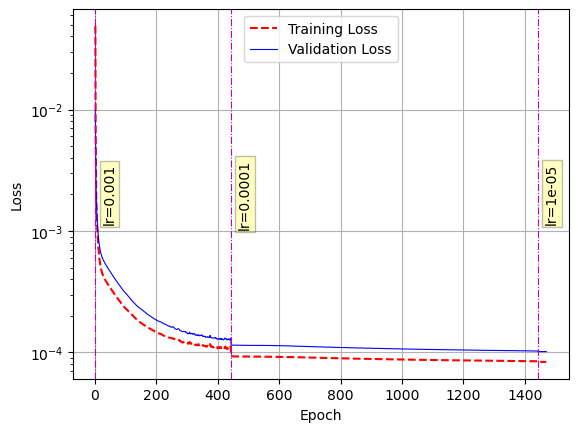

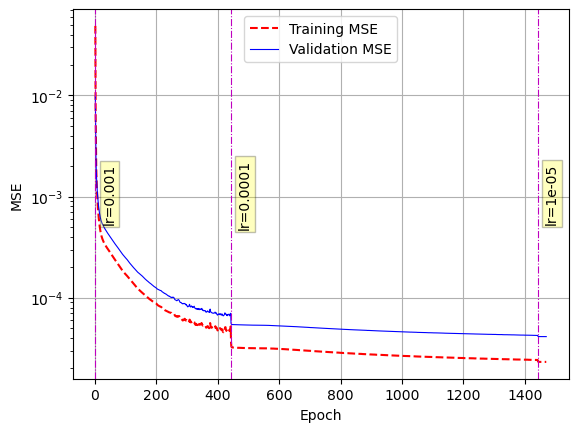

<Figure size 640x480 with 0 Axes>

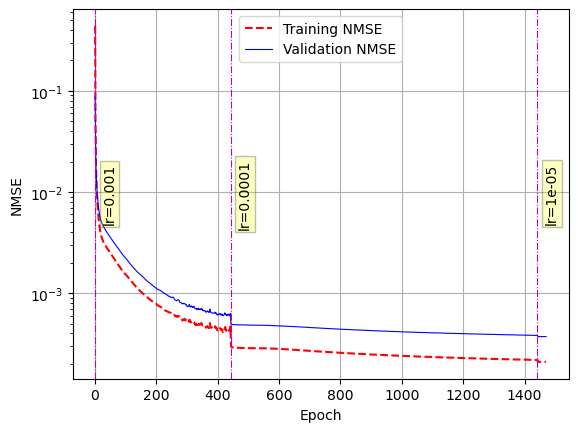

<Figure size 640x480 with 0 Axes>

In [37]:
# plotting losses
dir_name_plot = dir_name_rnn+dir_sep+'plots'
if not os.path.isdir(dir_name_plot):
    os.makedirs(dir_name_plot)

# Visualize loss history
fig, ax = plot_losses(
    training_loss=train_loss_hist,
    val_loss=val_loss_hist,
    lr_change=lr_change,
    learning_rate_list=learning_rate_list
)

plt.savefig(dir_name_rnn+'{ds}plots{ds}loss_history.png'.format(ds=dir_sep), dpi=300, bbox_inches='tight')
plt.show()


fig, ax = plot_losses(
    training_loss=train_MSE_hist,
    val_loss=val_MSE_hist,
    lr_change=lr_change,
    learning_rate_list=learning_rate_list,
    legend_list=['Training MSE', 'Validation MSE'],
    xlabel='Epoch',
    ylabel='MSE',
)
plt.savefig(dir_name_rnn+'/plots/MSE_history.png', dpi=300, bbox_inches='tight')
plt.show()
plt.clf()

fig, ax = plot_losses(
    training_loss=train_NMSE_hist,
    val_loss=val_NMSE_hist,
    lr_change=lr_change,
    learning_rate_list=learning_rate_list,
    legend_list=['Training NMSE', 'Validation NMSE'],
    xlabel='Epoch',
    ylabel='NMSE',
)
plt.savefig(dir_name_rnn+'/plots/NMSE_history.png', dpi=300, bbox_inches='tight')
plt.show()
plt.clf()

data_idx : 52


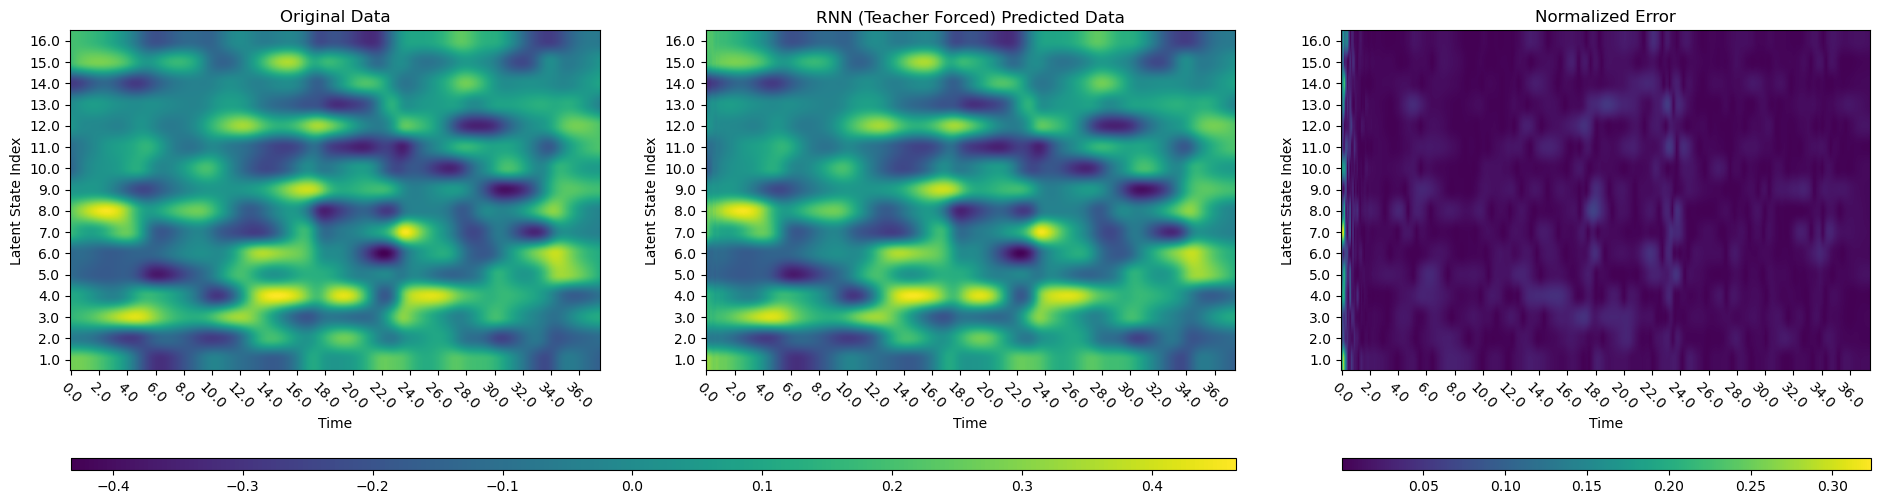

In [38]:
# data_type = 'training'
rnn_net.reset_states()
data_type = 'testing'

data_in = eval(data_type+'_data_rnn_input')
data_out = eval(data_type+'_data_rnn_output')

data_idx = np.arange(data_in.shape[0])
np.random.shuffle(data_idx)
data_idx = data_idx[0]
# data_idx = 3788
print('data_idx : {}'.format(data_idx))

# data_in = data_in[data_idx]
data_out = data_out[data_idx]

prediction = rnn_net.predict(data_in[data_idx:data_idx+1, :, :])

plot_reconstructed_data_KS(
    [data_out.shape[0]],
    dir_name_ae,
    data_out,
    prediction[0], delta_t, 1+np.arange(0, data_out.shape[1]),
    save_figs=False,
    normalization_constant_arr=normalization_arr,
    xticks_snapto=2,
    num_yticks=data_out.shape[1],
    ylabel=r'Latent State Index',
    ax1_title=r'Original Data',
    ax2_title=r'RNN (Teacher Forced) Predicted Data')

In [39]:
prediction.shape, data_out.shape

((32, 375, 16), (375, 16))

In [40]:
def rescale_data(data, normalization_arr):
    '''
    data - [num_batches x num_timesteps x num_states]
    normalization_arr = [2 x num_states]
    '''
    new_data = data.copy()
    shape = new_data.shape
    for i in range(data.shape[-1]):
        new_data[:, i] -= normalization_arr[0, i]
        new_data[:, i] /= normalization_arr[1, i]

    return new_data

def norm_sq_time_average(data):
    data_norm_sq = np.zeros(shape=data.shape[0])
    for i in range(data.shape[1]):
        data_norm_sq[:] += data[:, i]**2
    # integrating using the trapezoidal rule
    norm_sq_time_avg = np.sum(data_norm_sq) - 0.5*(data_norm_sq[0]+data_norm_sq[-1])
    norm_sq_time_avg /= data_norm_sq.shape[0]
    return norm_sq_time_avg

def invert_normalization(data, normalization_arr):
    new_data = data.copy()
    shape = new_data.shape
    for i in range(shape[-1]):
        if len(shape) == 2:
            new_data[:, i] *= normalization_arr[1, i]
            new_data[:, i] += normalization_arr[0, i]
        elif len(shape) == 3:
            new_data[:, :, i] *= normalization_arr[1, i]
            new_data[:, :, i] += normalization_arr[0, i]
    return new_data

case 1, data_idx : 26


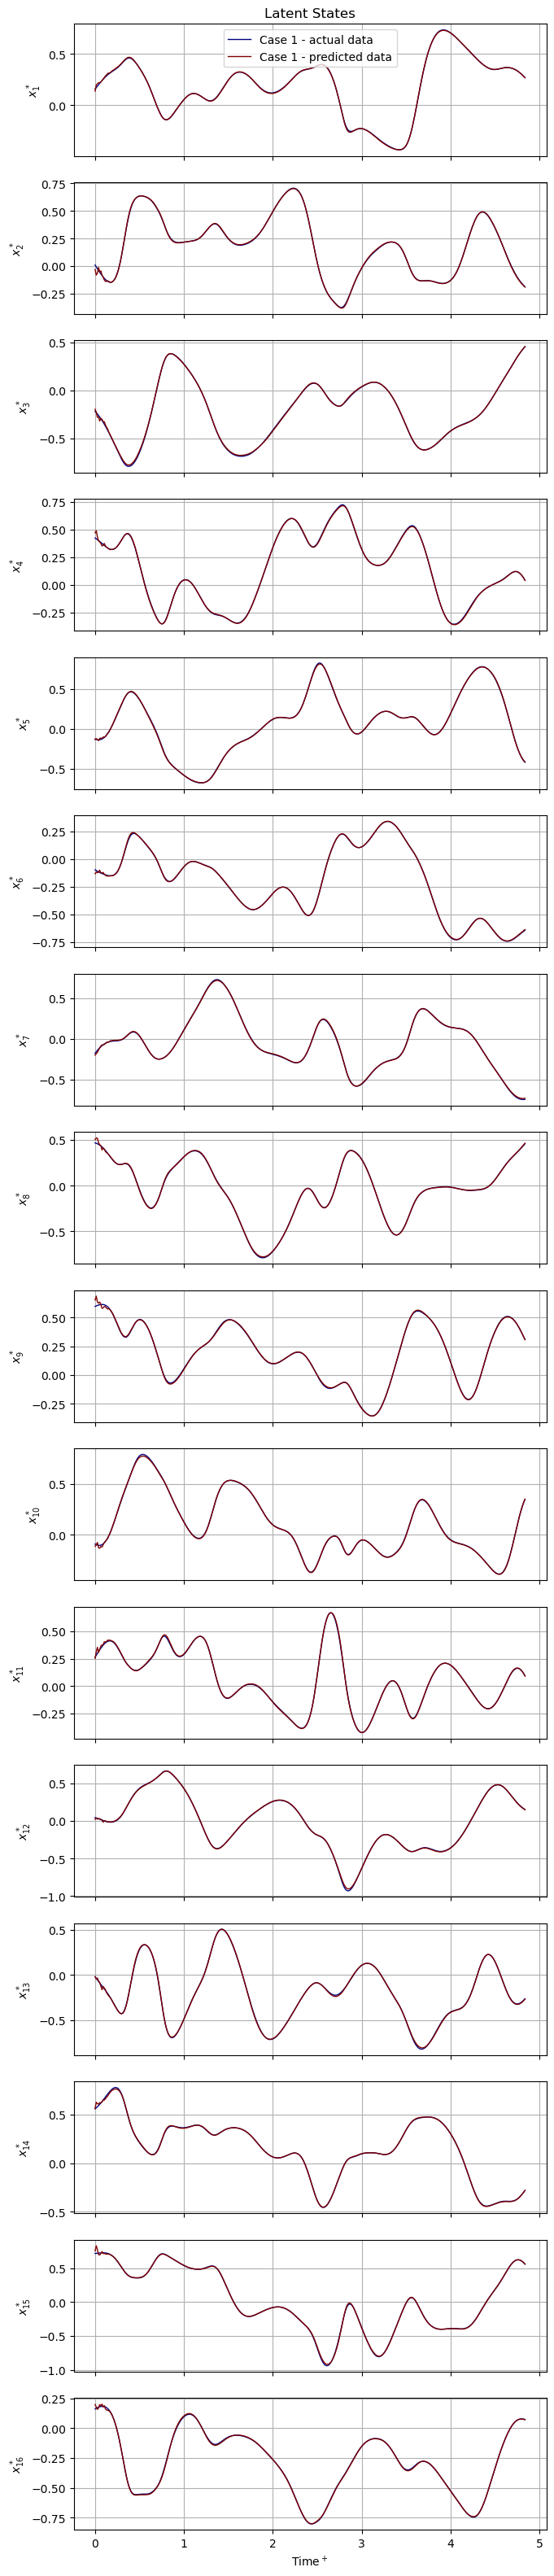


4.8363212491718865


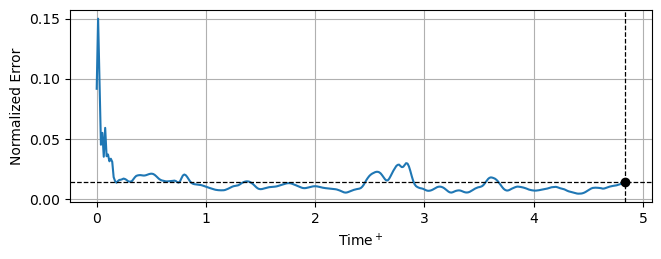

In [41]:
if rnn_net.stateful == True:
    for rnn_layer in rnn_net.rnn_list:
        rnn_layer.reset_states()


data_in = testing_data_rnn_input
data_out = testing_data_rnn_output

data_idx = np.arange(data_in.shape[0])
np.random.shuffle(data_idx)
data_idx = data_idx[0]
# data_idx = 11269
for i in range(len(rnn_data_boundary_idx_arr)):
    if data_idx < rnn_data_boundary_idx_arr[i]:
        case_idx = i
        break
lyap_time = lyapunov_time_arr[case_idx]

print('case {}, data_idx : {}'.format(case_idx+1, data_idx))

# data_in = data_in[data_idx]
data_out = data_out[data_idx]
# data_out = rescale_data(data_out, normalization_arr)
# data_out = invert_normalization(data_out, normalization_arr)

prediction = rnn_net.predict(data_in[data_idx:data_idx+1, :, :])
# prediction = rnn_net(data_in[data_idx:data_idx+1, :, :], training=False)
# prediction = rnn_net.call(data_in[data_idx:data_idx+1, :, :], training=False)
# prediction = invert_normalization(prediction, normalization_arr)

n = 1
num_latent_states = data_out.shape[-1]
N = data_out.shape[0]

num_cols = 1
num_rows = n*num_latent_states

ax_ylabels = ['$x^*_{' +str(i)+'}$' for i in range(1, num_latent_states+1)]

fig, ax = plt.subplots(num_latent_states, 1, sharex=True, figsize=(7.5*num_cols, 2.5*num_rows))
if num_latent_states == 1:
    ax = [ax]
input_time = np.arange(0, N)*dt_rnn/lyap_time

cmap = plt.get_cmap('jet')
colors = [cmap(i) for i in np.linspace(0, 1, 2*n)]

prev_idx = 0

mpl_ax_artist_list = []
for j in range(num_latent_states):
    for i in range(n):
        obj_in = ax[j].plot(input_time, data_out[:, j], linewidth=1, color=colors[2*i], label='Case {} - actual data'.format(i+1))
        obj_out = ax[j].plot(input_time, prediction[0, :, j], linewidth=1, color=colors[2*i+1], label='Case {} - predicted data'.format(i+1))
        mpl_ax_artist_list.append(obj_in[0])
        mpl_ax_artist_list.append(obj_out[0])
    ax[j].set_ylabel(ax_ylabels[j])
    # if xlim is not None:
    #     ax[j].set_xlim(xlim)
    # if ylim is not None:
    #     ax[j].set_ylim(ylim)
    ax[j].grid(True)
    ax[j].set_axisbelow(True)


ax[-1].set_xlabel('Time$^+$')

max_rows = 10
max_rows = float(max_rows)
ncols = int(np.ceil(len(boundary_idx_arr) / max_rows))
ax[0].legend(
    loc='best',
    ncol=ncols,
)
ax[0].set_title(r'Latent States', size=12)
plt.show()
# plt.savefig('AR-GRU.png', dpi=300, bbox_inches='tight')
print('')

### Error and prediction horizon
# error = np.linalg.norm(data_out[:, :] - prediction[0, :, :], axis=1)
error = (data_out[:, :] - prediction[0, :, :])**2
# error /= norm_sq_time_average(data_out)**0.5
error = np.mean(np.divide(error, time_stddev**2), axis=1)**0.5

# print(norm_sq_time_average(data_out)**0.5)

fig2, ax2 = plt.subplots(1, 1, figsize=(7.5, 2.5))
ax2.plot(input_time, error)
ax2.grid(True)
ax2.set_axisbelow(True)
ax2.set_xlabel('Time$^+$')
ax2.set_ylabel('Normalized Error')

error_threshold = 0.5

predhor_idx = np.where(error >= error_threshold)[0]
if predhor_idx.shape[0] == 0:
    predhor_idx = error.shape[0]-1
else:
    predhor_idx = predhor_idx[0]
ax2.plot(input_time[predhor_idx], error[predhor_idx], 'o', color='k')
ax2.axhline(error[predhor_idx], linewidth=0.9, linestyle='--', color='k')
ax2.axvline(input_time[predhor_idx], linewidth=0.9, linestyle='--', color='k')

prediction_horizon = predhor_idx*dt_rnn/lyap_time
print(prediction_horizon)

plt.show()

# Auto Regressive ESN

In [68]:
s_in = testing_data_rnn_input.shape
s_out = testing_data_rnn_output.shape

if stateful == True:
    temp1 = np.zeros_like(testing_data_rnn_input)
    temp2 = np.zeros_like(testing_data_rnn_output)
    testing_data_rolling_count = 0
    for i in range(len(rnn_data_boundary_idx_arr)):
        # idx = np.arange(begin_idx, rnn_data_boundary_idx_arr[i])
        num_samples = num_samples_arr[i]
        num_train = num_train_arr[i]
        num_val = num_val_arr[i]
        num_test = num_test_arr[i]

        nbatches_test = num_test // batch_size

        for j in range(batch_size):
            temp1[testing_data_rolling_count+j*nbatches_test:testing_data_rolling_count+(j+1)*nbatches_test] = testing_data_rnn_input[testing_data_rolling_count:testing_data_rolling_count+num_test:batch_size]
            temp2[testing_data_rolling_count+j*nbatches_test:testing_data_rolling_count+(j+1)*nbatches_test] = testing_data_rnn_output[testing_data_rolling_count:testing_data_rolling_count+num_test:batch_size]

        testing_data_rolling_count += num_test

    del(testing_data_rnn_input)
    testing_data_rnn_input = temp1
    del(testing_data_rnn_output)
    testing_data_rnn_output = temp2

testing_data_rnn_input = testing_data_rnn_input.reshape((1, s_in[0]*s_in[1]) + s_in[2:])
testing_data_rnn_output = testing_data_rnn_output.reshape((1, s_out[0]*s_out[1]) + s_out[2:])
# testing_data_rnn_input = testing_data_rnn_input.reshape((s_in[0], s_in[1], s_in[2]))
# testing_data_rnn_output = testing_data_rnn_output.reshape((s_out[0], s_out[1], s_out[2]))

In [69]:
T_sample_input_AR = 1*np.mean(lyapunov_time_arr)#50.1*dt_rnn
num_sample_input_AR = int((T_sample_input_AR+0.5*dt_rnn)//dt_rnn)

T_sample_output_AR = 5*np.mean(lyapunov_time_arr)
num_sample_output_AR = int((T_sample_output_AR+0.5*dt_rnn)//dt_rnn)

num_offset_AR = num_sample_input_AR
T_offset_AR = num_offset_AR*dt_rnn

batch_idx : 0
data_idx : 12685
data_.shape : (1, 464, 16)


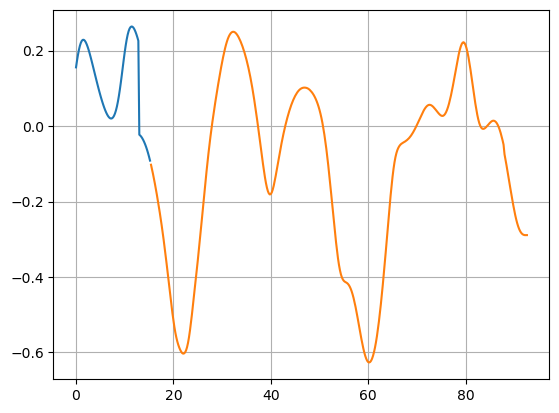

In [88]:
# data_to_consider = 'training'
data_to_consider = 'testing'

data_in = eval(data_to_consider+'_data_rnn_input')
data_out = eval(data_to_consider+'_data_rnn_output')

batch_idx = np.random.randint(low=0, high=data_in.shape[0])
maxpossible_num_runs = data_in.shape[1]-(num_sample_input_AR+num_sample_output_AR)

data_idx = np.random.randint(low=0, high=maxpossible_num_runs)

print('batch_idx : {}'.format(batch_idx))
print('data_idx : {}'.format(data_idx))
data_ = data_in[batch_idx:batch_idx+1, data_idx:data_idx+(num_sample_input_AR+num_sample_output_AR), :]
print('data_.shape :', data_.shape)

plt.plot(dt_rnn*np.arange(num_sample_input_AR), data_[0, 0:num_sample_input_AR, 0])
plt.plot(dt_rnn*num_sample_input_AR+dt_rnn*np.arange(num_sample_output_AR), data_[0, num_sample_input_AR:, 0])
plt.grid(True)
plt.show()

In [89]:
prediction_lst = []

for layer in rnn_net.rnn_list:
    layer.reset_states()

ar_rnn_input = np.tile(data_[:, 0:num_sample_input_AR, :], [batch_size, 1, 1])
input_preds = np.array(rnn_net(ar_rnn_input, training=False))

prediction_lst.append(input_preds[:, -1:, :])

for i in range(1, num_sample_output_AR):
    data_in_i = np.array(prediction_lst[-1])
    output = np.array(rnn_net(data_in_i, training=False))[:, -1:, :]
    prediction_lst.append(output)

In [90]:
prediction_lst = np.stack(prediction_lst)


print('input_preds.shape : {}'.format(input_preds.shape))
print('prediction_lst.shape : {}'.format(prediction_lst.shape))

input_preds.shape : (32, 77, 16)
prediction_lst.shape : (387, 32, 1, 16)


In [91]:
prediction_lst = np.transpose(prediction_lst, [1, 0, 2, 3])

In [92]:
print('prediction_lst.shape : {}'.format(prediction_lst.shape))

prediction_lst.shape : (32, 387, 1, 16)


In [93]:
prediction_lst = np.squeeze(predictions_lst)

In [94]:
print('prediction_lst.shape : {}'.format(prediction_lst.shape))

prediction_lst.shape : (32, 387, 16)


0.0


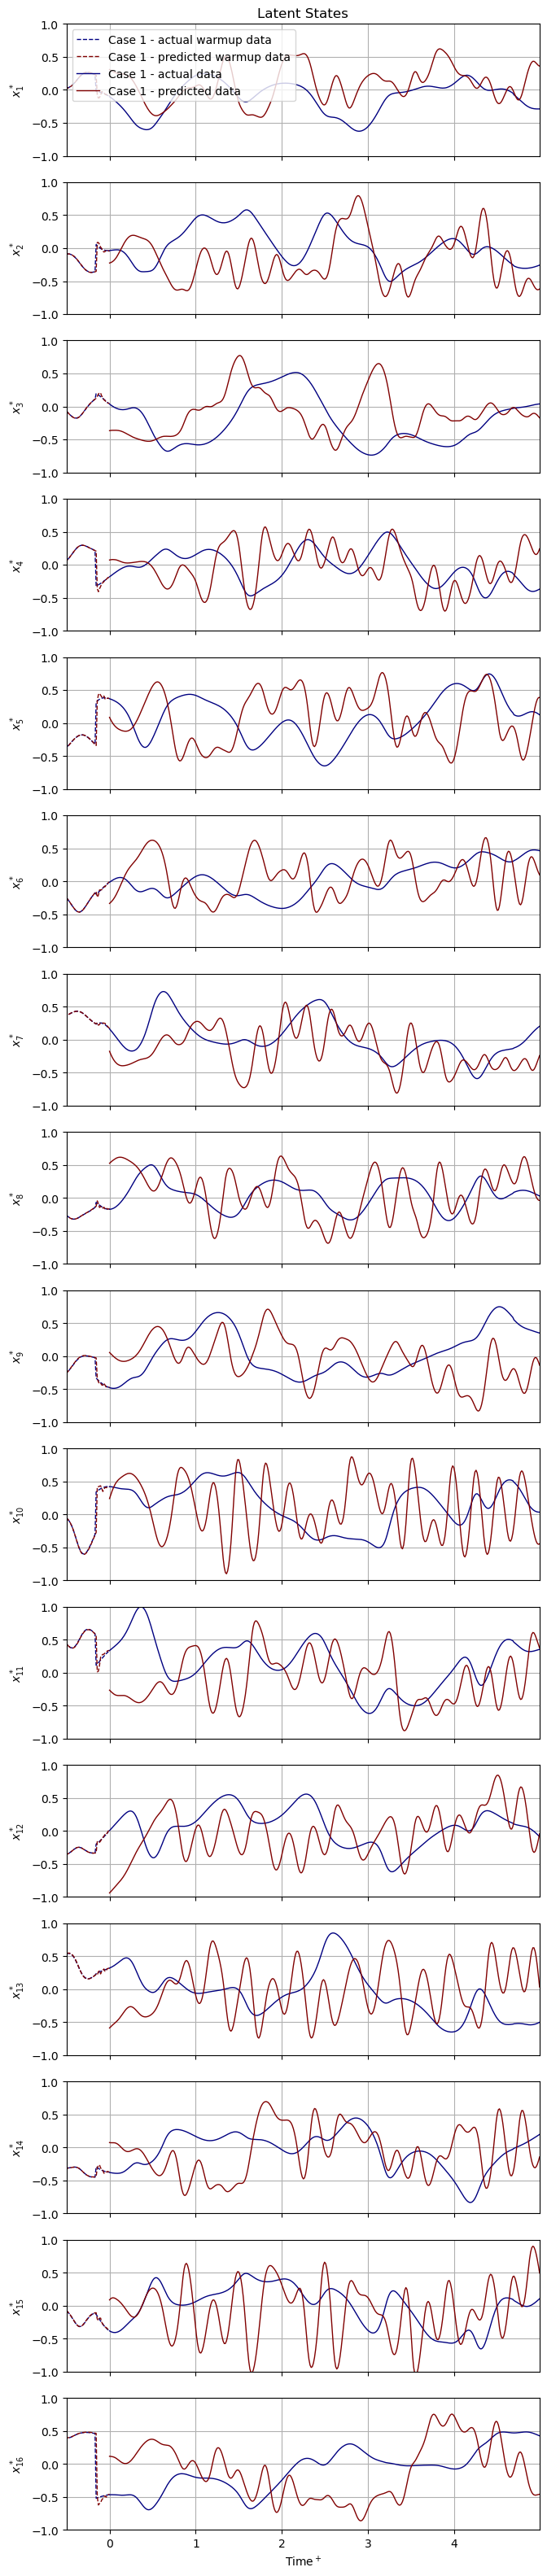

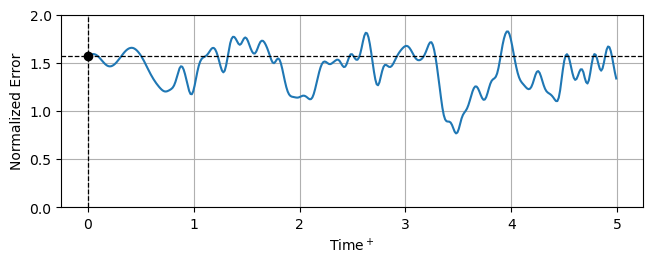

In [95]:
lyap_time = np.mean(lyapunov_time_arr)

n = 1
num_latent_states = input_preds.shape[-1]
N = num_sample_output_AR#num_output_timesteps

num_cols = 1
num_rows = n*num_latent_states

ax_ylabels = [r'$x^*_{'+str(i+1)+'}$' for i in range(num_latent_states)]

fig, ax = plt.subplots(num_latent_states, 1, sharex=True, figsize=(7.5*num_cols, 2.5*num_rows))
if num_latent_states == 1:
    ax = [ax]

cmap = plt.get_cmap('jet')
colors = [cmap(i) for i in np.linspace(0, 1, 2*n)]

prev_idx = 0

time_arr_warmup1 = (np.arange(num_sample_input_AR) - num_sample_input_AR)*dt_rnn
time_arr_warmup2 = time_arr_warmup1 + dt_rnn

time_arr_warmup1 /= lyap_time
time_arr_warmup2 /= lyap_time

input_time = time_arr_warmup2[-1]+np.arange(N, dtype=float)*dt_rnn/lyap_time

for j in range(num_latent_states):
    for i in range(n):
        ax[j].plot(time_arr_warmup1, data_[0, 0:num_sample_input_AR, j], linestyle='--', linewidth=1, color=colors[2*i], label='Case {} - actual warmup data'.format(i+1))
        ax[j].plot(time_arr_warmup2, input_preds[0, :, j], linestyle='--', linewidth=1, color=colors[2*i+1], label='Case {} - predicted warmup data'.format(i+1))
        ax[j].plot(input_time, data_[0, num_sample_input_AR:num_sample_input_AR+N, j], linewidth=1, color=colors[2*i], label='Case {} - actual data'.format(i+1))
        ax[j].plot(input_time, prediction_lst[0, :, j], linewidth=1, color=colors[2*i+1], label='Case {} - predicted data'.format(i+1))
    ax[j].set_ylabel(ax_ylabels[j])
    ax[j].grid(True)
    ax[j].set_axisbelow(True)
    ax[j].set_ylim([-1, 1])
    ax[j].set_xlim([input_time[0] - 0.5, input_time[-1]])


ax[-1].set_xlabel('Time$^+$')

max_rows = 10
max_rows = float(max_rows)
ncols = int(np.ceil(len(boundary_idx_arr) / max_rows))
ax[0].legend(
    loc='best',
    ncol=ncols,
)
ax[0].set_title(r'Latent States', size=12)


### error computation
error = (data_[0, num_sample_input_AR:num_sample_input_AR+N, :] - prediction_lst[0, :, :])**2
# error /= norm_sq_time_average(data_out)**0.5
error = np.mean(np.divide(error, time_stddev**2), axis=1)**0.5

# print(norm_sq_time_average(data_out)**0.5)

fig2, ax2 = plt.subplots(1, 1, figsize=(7.5, 2.5))
ax2.plot(input_time, error)
ax2.grid(True)
ax2.set_axisbelow(True)
ax2.set_xlabel('Time$^+$')
ax2.set_ylabel('Normalized Error')

error_threshold = 0.5

predhor_idx = np.where(error >= error_threshold)[0]
if len(predhor_idx.shape) == 0:
    predhor_idx = error.shape[0]-1
else:
    predhor_idx = predhor_idx[0]
ax2.plot(input_time[predhor_idx], error[predhor_idx], 'o', color='k')
ax2.axhline(error[predhor_idx], linewidth=0.9, linestyle='--', color='k')
ax2.axvline(input_time[predhor_idx], linewidth=0.9, linestyle='--', color='k')
ax2.set_ylim([0, 2])

prediction_horizon = predhor_idx*dt_rnn/lyap_time
print(prediction_horizon)

In [59]:
if use_weights_post_dense == True:
    print(rnn_net.postWout.individual_weights)

<tf.Variable 'single_weights/individual_weights:0' shape=(16,) dtype=float32, numpy=
array([1.5877793, 1.7399802, 1.6654323, 1.6431468, 1.6886216, 1.6698226,
       1.6727579, 1.7623531, 1.726447 , 1.73515  , 1.8289636, 1.6196005,
       1.7639221, 1.7103784, 1.7418543, 1.7284263], dtype=float32)>


In [60]:
def plot_histogram_and_save(
    prediction_horizon_arr,
    save_dir,
    savefig_fname='pre_ARtraining',
    bin_width=0.05,
    bin_begin=0.0):
    
    fig, ax = plt.subplots()

    ph_mean = np.mean(prediction_horizon_arr)
    ph_stddev = np.std(prediction_horizon_arr)
    ph_max = np.max(prediction_horizon_arr)
    ph_min = np.min(prediction_horizon_arr)
    
    bin_end = bin_width*np.round((np.max(prediction_horizon_arr)+0.5*bin_width)//bin_width)
    nbins = int(np.round(bin_end/bin_width))

    ax.hist(prediction_horizon_arr, bins=nbins, range = [bin_begin, bin_end], density=True)
    ax.axvline(ph_mean, linewidth=0.9, linestyle='--', color='k')

    ax.set_xlabel('Prediction Horizon (Lyapunov times)')
    ax.set_ylabel('PDF')

    ax.grid(True)
    # ax.set_axisbelow(True)

    ax.text(
        0.01 + ax.transAxes.inverted().transform(ax.transData.transform([prediction_horizon, 0]))[0],
        0.8,
        'mean',
        rotation=90,
        verticalalignment='bottom',
        horizontalalignment='left',
        bbox=dict(facecolor=np.array([255,255,153])/255, alpha=1, boxstyle='square,pad=0.2'),
        transform=ax.transAxes
    )

    text_xy = [0.95, 0.95]
    ax.text(
        text_xy[0],
        text_xy[1],
        'mean : {:.4f}\nmax : {:.4f}\nmin : {:.4f}\nstddev : {:.4f}'.format(
            ph_mean,
            ph_max,
            ph_min,
            ph_stddev,
        ),
        transform=ax.transAxes,
        bbox=dict(
            boxstyle="round",
            ec=(0.6, 0.6, 1),
            fc=(0.9, 0.9, 1),
        ),
        # bbox=dict(facecolor='C0', alpha=0.5, boxstyle='round,pad=0.2'),
        horizontalalignment='right',
        verticalalignment='top'
    )

    ax.set_title('nbins = {}'.format(nbins))
    
    if not os.path.isdir(save_dir):
        os.mkdir(save_dir)

    fig.savefig(save_dir+'/'+savefig_fname+'.png', dpi=300, bbox_inches='tight')
    fig.clear()
    plt.close()

In [63]:
num_runs = 100
num_runs = np.min([num_runs, maxpossible_num_runs])
print(num_runs)

data_idx_arr = np.linspace(0, maxpossible_num_runs-1, num_runs, dtype=np.int32)

savefig_fname = 'pre_ARtraining-'+data_to_consider+'data'
npsavedata_fname = '/prediction_horizons-'+data_to_consider+'data'
plot_dir = '/plots'

analysis_time = time.time()

sidx1 = dir_name_rnn[::-1].index('/')
sidx2 = dir_name_rnn[-sidx1-2::-1].index('/')
print(dir_name_rnn[-(sidx1+sidx2+1):])

prediction_horizon_arr = np.empty(shape=num_runs)

for i in range(num_runs):
    data_idx = data_idx_arr[i]

    # for j in range(len(rnn_data_boundary_idx_arr)):
    #     if data_idx < rnn_data_boundary_idx_arr[j]:
    #         case_idx = j
    #         break
    lyap_time = lyapunov_time_arr[0]

    ### picking the data
    data_ = data_in[0:1, data_idx:data_idx+(num_sample_input_AR+num_sample_output_AR), :]

    ### doing the predictions
    prediction_lst = []

    for layer in rnn_net.rnn_list:
        layer.reset_states()

    ar_rnn_input = np.tile(data_[:, 0:num_sample_input_AR, :], [batch_size, 1, 1])
    input_preds = np.array(rnn_net(ar_rnn_input, training=False))

    prediction_lst.append(input_preds[:, -1:, :])

    for j in range(1, num_sample_output_AR):
        data_in_j = np.array(prediction_lst[-1])
        output = np.array(rnn_net(data_in_j, training=False))[:, -1:, :]
        prediction_lst.append(output)
        
    prediction_lst = np.stack(prediction_lst)
    prediction_lst = np.squeeze(prediction_lst)
    prediction_lst = np.transpose(prediction_lst, [1, 0, 2])[0]
    # prediction_lst = invert_normalization(prediction_lst, normalization_arr)
    
    input_preds = input_preds[0, :, :]
    
    data_out = data_[0, num_sample_input_AR:num_sample_input_AR+num_sample_output_AR, :]
    # data_out = invert_normalization(data_out, normalization_arr)

    ### Error and prediction horizon
    # error = np.linalg.norm(data_out[:, :] - prediction[i, :, :], axis=1)
    error = (data_out[:, :] - prediction_lst[:, :])**2
    # error /= norm_sq_time_average(data_out)**0.5
    error = np.mean(np.divide(error, time_stddev**2), axis=1)**0.5 # use time_stddev_AEproducedlatentstates if using invert_normaliztion

    predhor_idx = np.where(error >= error_threshold)[0]
    if predhor_idx.shape[0] == 0:
        predhor_idx = error.shape[0]
    else:
        predhor_idx = predhor_idx[0]

    prediction_horizon_arr[i] = predhor_idx*dt_rnn/lyap_time

median_idx = int(np.round(0.5*num_runs-1))
quartile_1_idx = int(np.round(0.25*num_runs-1))
quartile_3_idx = int(np.round(0.75*num_runs-1))

prediction_horizon_arr.sort()

median = prediction_horizon_arr[median_idx]
quartile_1 = prediction_horizon_arr[quartile_1_idx]
quartile_3 = prediction_horizon_arr[quartile_3_idx]
IQR = quartile_3 - quartile_1

prediction_horizon = np.mean(prediction_horizon_arr)
stddev_ph = np.std(prediction_horizon_arr)

s = 'num_runs : {}, error_threshold = {}\n'.format(num_runs, error_threshold)
s += 'prediction_horizon : {}, median : {}\n'.format(prediction_horizon, median)
s += 'ph_min : {}, ph_max : {}\n'.format(prediction_horizon_arr.min(), prediction_horizon_arr.max())
s += 'stddev : {}, IQR : {}\n'.format(stddev_ph, IQR)
s += '1st quartile : {}, 3rd quartile : {}'.format(quartile_1, quartile_3)

print('\n'+s)

plot_histogram_and_save(
    prediction_horizon_arr,
    save_dir=dir_name_rnn+plot_dir,
    savefig_fname=savefig_fname
)

npsavedata_fname = '/prediction_horizons-'+data_to_consider+'data'
np.savez(
    dir_name_rnn+npsavedata_fname,
    prediction_horizon_arr=prediction_horizon_arr,
    error_threshold=error_threshold,
)

with open(dir_name_rnn+npsavedata_fname+'--statistics.txt', 'w') as fl:
    fl.write(s)

print('analysis time : {} s\n'.format(time.time() - analysis_time))

100
saved_ESN/ESN_029

num_runs : 100, error_threshold = 0.5
prediction_horizon : 0.43526891242546983, median : 0.3879402071528252
ph_min : 0.0, ph_max : 1.073301239789483
stddev : 0.18550249835878943, IQR : 0.1551760828611301
1st quartile : 0.3362148461991151, 3rd quartile : 0.49139092906024523
analysis time : 66.05155539512634 s

